# ML Project  - Learning about Pet Adoption using PetFinder.my Dataset

Beatriz Lima 49377, David Almeida 54120, Tiago Pereira 49174
___________________

## Table of Contents



#### Task 0 (Know your Data) - Exploratory Data Analysis
  * 0.1. Loading Data
  * 0.2. Understanding Data
    + Basic Questions
    + Exploratory Data Analysis

#### Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed
  * 1.1. Preprocessing Data for Classification
    + Features impact
    + Data imbalance
    + Feature Encoding
    
    
  * 1.2. Learning Classifiers
    + 1.2.1 Benchmark
        - 1.2.1.1 Predicting Adoption (binary classification task)
        - 1.2.1.2 Predicting AdoptionSpeed (multiclass classification task) 
    + 1.2.2 Predicting Adoption (binary classification task)
    + 1.2.3 Predicting Adoption Speed (Multiclass classification task)
    + 1.2.4 Predicting Adoption/Adoption Speed for dogs
        - 1.2.4.1 Binary Classification
        - 1.2.4.2 Multiclass Classficiation
    + 1.2.5 Predicting Adoption/Adoption Speed for cats
        - 1.2.5.1 Binary Classification
        - 1.2.5.2 Multiclass Classficiation
   
   * 1.3. Classification - Results and Discussion 
   
#### Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

   * Associoation Rule Mining:
   
       + 2.1. Preprocessing Data for Association Rule Mining
       + 2.2. Finding Associations
           + Binary dataset
           + Multiclass dataset
       + 2.3 Association Rules - Results and Discussion 
   
   * Clustering:
      + 2.4. Preprocessing Data for Clustering
      + 2.5. Finding Groups
          - Binary Analysis
          - Multiclass Analysis
      + 2.6. Clustering - Results and Discussion
    
#### Task 3 - Final Comments and Conclusions
 

## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import statistics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import neighbors,tree, preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, recall_score, accuracy_score
import sklearn.naive_bayes
#from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB ,CategoricalNB
from sklearn.ensemble import RandomForestClassifier
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from IPython.display import Image  
from sklearn import tree
import pydotplus

In [211]:
df = pd.read_csv('PetFinder_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Loading colour, breed and state labels:

In [ ]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### When data entries are blank, where does that come from?
Some animal profiles have no assigned name. There are also some features which have a default value set for cases in which that feature is not specified or applicable to the data entry.

#### How common are blank entries?
There are ~1200 blank name entries, which constitute a significant portion of the data. It would perhaps be best to keep this data in the dataset for analysis. Other features with default value entries should also be kept, because, like a profile without a name, unspecified animal characteristics have a meaning relevant to our objectives.

## Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for `AdoptionSpeed = 0`. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

In [ ]:
ax = sns.catplot(x="AdoptionSpeed",data=df, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

### Overall correlations
The plot bellow illustrates the absolute correlation between  each feature and the target class `AdoptionSpeed`. All correlations are very low (<15%)

In [ ]:
numeric_df = df.select_dtypes(exclude=['object'])
corr_dict = {}
for feature in numeric_df.columns:
    corr_dict[feature] = abs(df['AdoptionSpeed'].corr(df[feature]))
    #print(feature, '-->', corr_dict[feature])
    
corr_dict.pop('AdoptionSpeed')
plt.figure(figsize=(20,7))
plt.bar(range(len(corr_dict)), list(corr_dict.values()), align='center')
plt.xticks(range(len(corr_dict)), list(corr_dict.keys()))

### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

In [212]:
df.set_index("PetID", inplace=True) # change index to PetId
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


### Strategy

The following analysis was done to each feature:
* Check the number of examples for each feature values.
* Check the distribution of each feature values' among AdoptionSpeed classes.

For the second step we used the following visualisation method, which returns not only a plot on the distribution but also a table of representativity percentage gain of each feature's values for each `AdoptionSpeed` class, relative to `AdoptionSpeed = 0`:

In [213]:
# creates a stacked bar plot for any two categorical variables
# also creates a relative frequency version of the same plot
# and a relative gain compared to AdoptionSpeed=0 
# frel=False to return only the absolute frequency plot

def cat_distr_pairwise(cat_x,cat_y, df, frel):
    
    unique_cat_y = sorted(df[cat_y].unique()) #ordered list of categories in variable y
    unique_cat_x = sorted(df[cat_x].unique()) #ordered list of categories in variable x
    cat_count = pd.DataFrame(columns=unique_cat_y,index=unique_cat_x) #DataFrame of x categories by y categories
    for y in unique_cat_y: #count each type of y category...
        for x in unique_cat_x: #... for each type of x category (e.g.: all dogs' adoption speed, then all cats' adoption speed)
            count = df[cat_y][(df[cat_x]==x) & (df[cat_y]==y)].count() 
            cat_count.at[x,y] = count 
    
    def color(val):
        if val < 0:
            color = 'red'
        elif val>0:
            color = 'green'
        else:
            color='white'
        return 'background-color: %s' % color
    
    if frel==False:
        
        #relative gain table
        relgain = cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        # alternative: display(relgain.style.bar(align='zero', color=['#d65f5f', '#5fba7d'])
        return cat_count.plot.bar(stacked=True, figsize=(10,7))
    
    else:
        #relative frequency stacked bar plot
        freq_cat_count = cat_count.divide(cat_count.sum(axis=1), axis=0)
        
        #relative gain table
        relgain = freq_cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        # alternative: display(relgain.style.bar(align='zero', color=['#d65f5f', '#5fba7d'])

        return freq_cat_count.plot.bar(stacked=True, figsize=(10,7), title=cat_y + " relative distribution among AdoptionSpeed")
    

We will now present the most important conclusions taken from this analysis.

### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

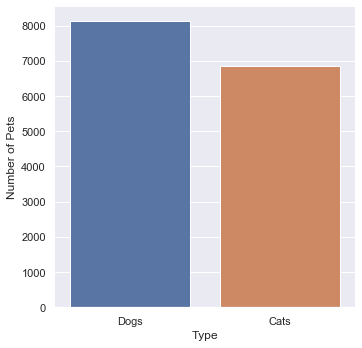

In [214]:
bx = sns.catplot(x="Type",data=df, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

Relative gain from AdoptionSpeed=0 (%):


,1,2
0,nan,nan
1,12.0027,-8.50189
2,27.429,-21.8776
3,38.9943,-35.2397
4,35.1712,-29.5518


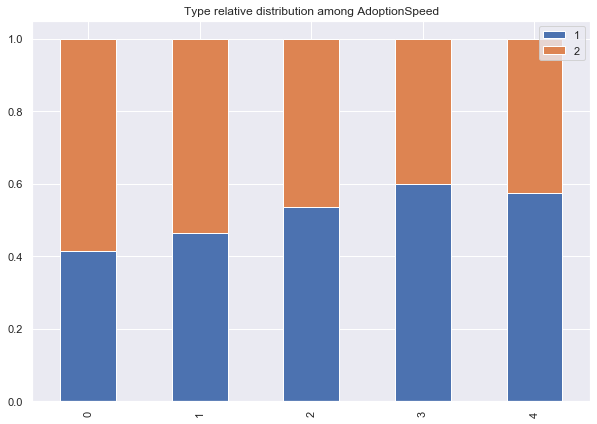

In [215]:
cat_distr_pairwise('AdoptionSpeed','Type', df, frel=True)

Looking at our data, the number of examples of dogs and cats is fairly proportional, as well as their relative distribution among target classes. 
Looking at the gain table, it is clear that dogs (1) tend to get adopted later relative to cats (2), which we can see by the growing relative gain. In fact, the number of dogs with no adoption after 100 days (`AdoptionSpeed = 4`) is 37% higher than dogs being adopted on the same day (`AdoptionSpeed = 0`). On the other hand, we observe the opposite phenomena on cats. They tend to be adopted at ealier stages, being the number of cats with no adoption after 100 days (`AdoptionSpeed = 4`) is 29% lower than cats being adopted on the same day (`AdoptionSpeed = 0`).
Despite this small discrepancies, we expect the resulting models' performance to be comparable.



### Name
Since a reasonable amount of the profiles didn't make any reference to name (empty) a first approach would be to fill those empty values with a fixed value such as "No Name" or similar.
Other approach would be to transform this feature into a binary one with a 0 value for profiles with no name and a 1 value for the opposite.
Since it was later found that some of the named profiles were filled with "No Name" and derivatives of this name such as "No Name Yet", "V6", "å°è±¹çº¹" etc., which are not proper names, we made an attempt to classify those cases as "No name" as well.

A glimpse on the ignored names: ['No Name Yet', 'No Name', 'No Name', 'H3', 'Z3', 'C', 'No Name', 'No Name', 'BB', 'QQ', 'Y1', 'No Name', 'H1', 'No Name Yet', 'D9', 'Y4', 'No Name', 'Z4', 'No Name', 'Unnamed', 'BB', 'DD', 'M2', 'H6', 'D4', 'QQ', 'JJ', 'No Names', 'å°\x8fè±¹çº¹', 'ä¼\x98ç¾\x8eå\x8f¯ç¬\x91', 'F1', 'æ©\x98å\xad\x90', 'W7', '(No Name)', 'No Name Yet', 'No Name', '1F', 'Q1', '6', 'CJ', '3F', '[No Name]', 'BB', 'KD', 'No Name Yet', 'No Name Yet', 'DD', 'No Name', 'G1', 'è\x8f\x9cè\x8f\x9cã\x80\x82']


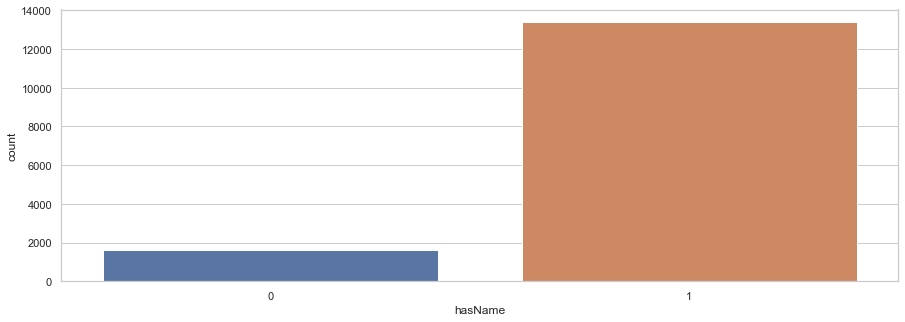

In [216]:
# Create new feature - hasNames
l = []
ignore = []

for i in df["Name"]:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        if len(i)<3: #Consider that a 2 letter name is not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("[a-zA-Z]", i) == None: #If name doesn't have letters, it's not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("unnamed|no name",i, re.IGNORECASE) != None: 
            #If name string includes "unnamed" or "no name", it's not a proper name
            l.append(0)
            ignore.append(i)
        elif len(i.split())>0:
            l.append(1)

print("A glimpse on the ignored names:",ignore[:50])
df_processed1 = df.copy()
df_processed1.drop("Name", axis=1, inplace = True)
df_processed1.insert(1,"hasName",l) ##INSERT IN DATAFRAME

sns.set(style="whitegrid")
ax = sns.countplot(x="hasName", data=df_processed1)

In [ ]:
cat_distr_pairwise('AdoptionSpeed','hasName', df_processed1, frel=True)

As we can see from the plot above, the relative distribution of the "noName" feature values among `AdoptionSpeed` classes is very similar. This probabably means that the pet's name is not a very important factor in the adopter's decision.

### Age

When looking at `Age` distribution, we can see that there are peaks every 12 months. Young pets (less than 1 year old) are the most frequent.

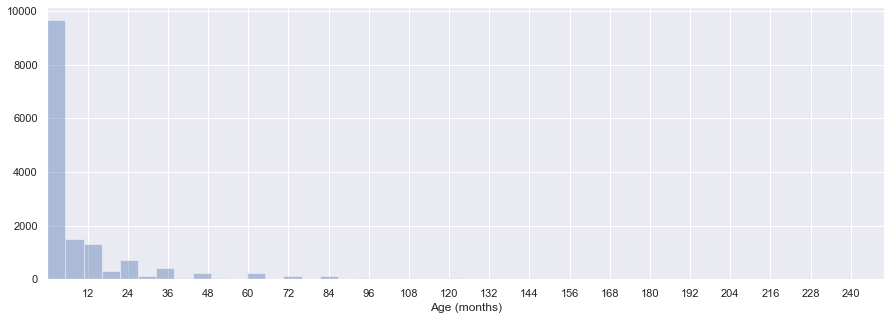

In [217]:
a = df['Age'] # get Age array
nr_bins = 1 + 3.322*math.log(len(a),2) # Number of bins according to Sturges rule
sns.set(rc={'figure.figsize':(15,5)}) # set figure size

# setting up the axis
fig, ax = plt.subplots()
ticks = [i for i in range(0,260,12)]
ticks.pop(0)
ax.set_xticks(ticks)
plt.xlim([0.0,250])

sns.distplot(a, bins=round(nr_bins), kde=False, axlabel="Age (months)");

The average cat is considered a kitten roughly until it reaches the age of 1 year old. The same goes for puppies. On the other hand, dogs and cats are considered Seniors roughly when they reach the age of 6 years. Of course, these are approximations, as the classification varies with the type of animal (cats or dogs), breed, size and many other factors.

In this sense, we will consider these categories:
* Baby - age 0-11 months => 0
* Adult - age 12-71 months =>1
* Senior - age 72-250 months =>2

In [218]:
# Create new feature - AgeGroup
AgeGroup = []
for i in df["Age"]:
    if i<12:
        AgeGroup.append(0)
    elif i<72:
        AgeGroup.append(1)
    else:
        AgeGroup.append(2)

df_processed2 = df_processed1.copy()
df_processed2.drop("Age", axis=1, inplace = True)
df_processed2.insert(2,"AgeGroup",AgeGroup) ##INSERT IN DATAFRAME

In [ ]:
cat_distr_pairwise('AdoptionSpeed','AgeGroup', df_processed2, frel=True)

The relative distribution of `AgeGroup` among `AdoptionSpeed` indicates that there seems to be no particular correlation between being younger and getting adopted earlier. Even without the dicretization we can observe the same phenomena: 

In [ ]:
plt.figure(figsize=(10,15))
plt.ylim(0, 260)
sns.boxplot(data = df, x='AdoptionSpeed', y='Age')

### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

In [ ]:
bx1 = sns.catplot(x="Breed1",data=df, kind='count',height=9, aspect=3)
bx2 = sns.catplot(x="Breed2",data=df, kind='count',height=9, aspect=3)

Looking at our data, and according to the breeds feature labels, we found some cats with dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds in which some breeds are poorly representated perhaps a good idea should be grouping pets by pure-race/mixed-race.

In [219]:
#Creating new feature: Pure breed
l3 =[]
for i in range(len(df)):
    if df['Breed1'][i]==307 or df['Breed2'][i]==307:
        l3.append(0)
    elif df['Breed1'][i]!=307 and df['Breed2'][i]==0:
        l3.append(1)
    elif df['Breed1'][i]==0 and df['Breed2'][i]!=307:
        l3.append(1)
    elif df['Breed1'][i]==df['Breed2'][i]:
        l3.append(1)
    else:
        l3.append(0)
        
df_processed2.drop("Breed1",axis=1,inplace=True)
df_processed2.drop("Breed2",axis=1,inplace=True) 
df_processed2.insert(3,'PureBreed',l3) ##INSERT IN DATAFRAME

In [ ]:
cat_distr_pairwise('AdoptionSpeed','PureBreed', df_processed2, frel=True)

From the plot and relative gain table we conclude that pure breed animals (1) tend to be adopted earlier, whereas mixed breed animals (0) are adopted later.

### Quantity

Number of pets represented in profile

In [ ]:
ax3 = sns.catplot(x='Quantity', data=df, kind='count')
(ax3.set_axis_labels("Quantity", "Number of Pets"))
print('There are {} profiles with a single pet'.format((list(df['Quantity'])).count(1)))
print('There are {} profiles with multiple pets'.format(len(df['Quantity'])-list(list(df['Quantity'])).count(1)))

In [ ]:
ste = cat_distr_pairwise('AdoptionSpeed','Quantity', df, frel=True)

The "inf" values on the table indicate that there are no examples of a pet with `AdoptionSpeed = 0` for that feature instance. Therefore, all positive relative gains are 'infinite'.

We can conclude that adds containing more than 5 pets could be more likely to be ignored, since those pets are adopted after a long time.

### Fee

After observing the fees' distribution we considered 4 categories: 
* Free => 0
* Tens => 1
* Hundreds => 2
* Thousands => 3


In [220]:
f=[]
for i in df["Fee"]:
    if i==0:
        f.append(0)
    elif i<100:
        f.append(1)
    elif i<1000:
        f.append(2)
    else:
        f.append(3)

df_processed2.drop("Fee",axis=1,inplace=True) 
df_processed2.insert(4,'Free',f) ##INSERT IN DATAFRAME

In [ ]:
fee = cat_distr_pairwise('AdoptionSpeed','Free', df_processed2, frel=True)

It seems that pets with fees in the order of the thousands are less likely to be adopted fast.

### RescuerID

In order to extract some meaning from the `RescuerID`, we decided to create a new feature `FrequentRescuer` which indicates whether it is frequent for rescuers to save and advertise pets. After visiting *www.PetFinder.my*, we noticed pet profiles include links to other profiles by the same rescuer. In this way, it is plausible that users, while browsing the website, will look at related profiles more often than profiles by different users, thereby influencing adoption rates.

There are 5595 total rescuers in the dataset
There are 3783 rescuers with only 1 webpage entry in the dataset
There are 1812 rescuers with more than 1 webpage entry in the dataset


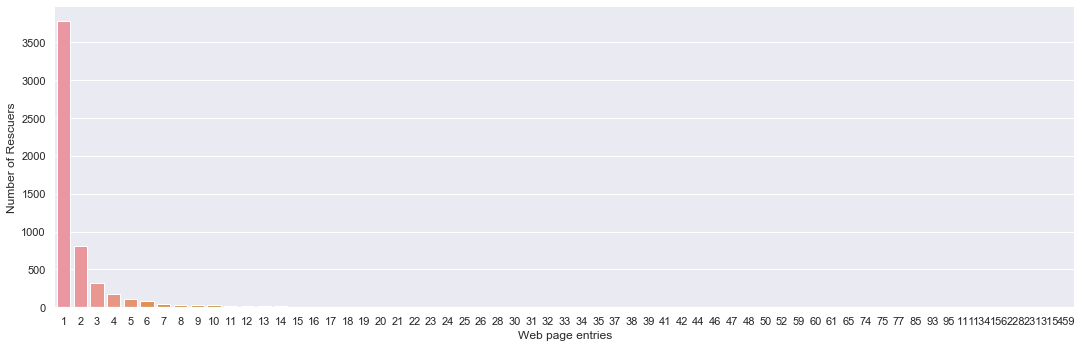

In [10]:
x = list(df['RescuerID'].unique())
y = list(df['RescuerID'])
z = []
t = {}
for i in x:
    z.append(y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} total rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Web page entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

According to the dataset, the number of rescuers with a single entry in the PetFinder webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover whether the number of webpage profile entries associated with a rescuer has any effect in pet adoption/adoption speed.

An important aspect of this analysis is that, given we have access to around ~10% of the global dataset, it is possible that many ID's described as non-frequent may be mislabeled (if other instances of the ID are present in the remaining ~90% of data).

In [221]:
#CREATE NEW FEATURE FREQUENTRESCUER

lista2 = []
y = list(df['RescuerID'])
for i in df['RescuerID']:
      if y.count(i)>1:
          lista2.append(float(1))
      else:
          lista2.append(float(0))
          
df_processed1.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed1.drop("RescuerID", axis=1, inplace=True)

df_processed2.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed2.drop("RescuerID", axis=1, inplace=True)

### VideoAmt

There are 14419 profiles with 0 videos
There are 574 profiles with more than 0 videos


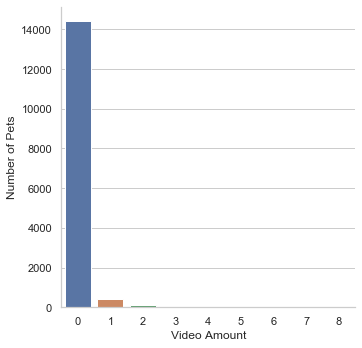

In [297]:
ax2 = sns.catplot(x='VideoAmt', data=df, kind='count')
(ax2.set_axis_labels("Video Amount", "Number of Pets"))
print('There are {} profiles with 0 videos'.format((list(df['VideoAmt'])).count(0)))
print('There are {} profiles with more than 0 videos'.format(len(df['VideoAmt'])-list(list(df['VideoAmt'])).count(0)))

Given the distribution of pets, we will consider this feature as binary: has Video (1) or does not have Video (0).

In [298]:
hasVideo=[]

for v in df['VideoAmt']:
    if v==0:
        hasVideo.append(0)
    else:
        hasVideo.append(1)
        
df_processed2.drop("VideoAmt", axis=1,inplace=True)
df_processed2.insert(5,"hasVideo",hasVideo) ##INSERT IN DATAFRAME

KeyError: "['VideoAmt'] not found in axis"

### Description

In order to extract some meaning from the `Description`, we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (`size=0`) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization process.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium'-sized description is. In that sense, a 'medium'-sized description would have the average word count. Analogously, the smallest and largest descriptions would correspond to the first and third quantiles.

The average descripton size: 62.953645034349364
According to this discretization, the bin edges should be:
[array([   0.,   28.,   65., 1257.])]


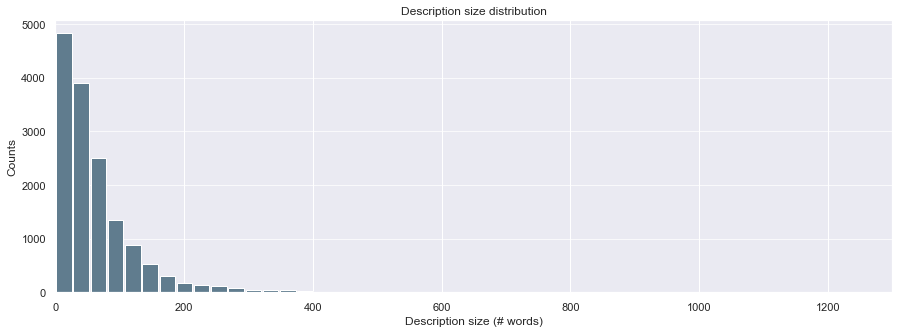

In [13]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0.0,1300])

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* `Empty` for descriptions containing 0 words => 0
* `Small` for descriptions containing 1-28 words => 1
* `Medium` for descriptions containing 29-65 words => 2
* `Large` for descriptions containing 66-1257 words => 3

In [223]:
#Create new feature 'Description size'
d = []

for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        d.append(0)
    else:
        a= len(i.split())
        if a<29:
            d.append(1)
        elif a<66:
            d.append(2)
        else:
            d.append(3)    
            
df_processed1.drop("Description", axis=1, inplace=True)
df_processed1.insert(6,"DescriptionSize",l) ##INSERT IN DATAFRAME

df_processed2.drop("Description", axis=1, inplace=True)
df_processed2.insert(6,"DescriptionSize",d) ##INSERT IN DATAFRAME

### Other conclusions
* Pets with maturity size `Small` (1) and `Extra Large`(4) are less likely to be in the adoption centre for a very long time (-45.0552% and -97.3772 of pets at `AdoptionSpeed = 4` relatively to `AdoptionSpeed = 1`, respectively). 
* Pets with long fur (3) very rarely stay at the adoption centre for a long time (-116.814% of pets at `AdoptionSpeed = 4` relatively to `AdoptionSpeed = 1`).
* Sterilized pets tend to be adopted later (+82.13% of pets at `AdoptionSpeed = 4` relatively to `AdoptionSpeed = 1`).
* Pets with serious injuries (`Health = 3`) are very more likely to be adopted after a long time, or not adopted at all (+182.091% of pets at `AdoptionSpeed = 4` relatively to `AdoptionSpeed = 1`). 
* No pets were adopted in the same day having the add not provide a description!
* There was no clear evidence that the distribution of the features values among `AdoptionSpeed` classes was biased for features `Gender`, `Vaccinated`, `Dewormed`, `State`, `FrequentRescuer`.

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

## 1.1. Preprocessing Data for Classification

During our EDA we already preprocessed some of the features, for data visualization purposes. The result are two datasets:
* **df_processed1**: which we will use to benchmark the models' performance without the discretization of features discussed earlier, since they can remove the fine grain information that might be beneficial to the learning proccess. Some data cleaning was done, namely in features `PetID`, `Name`, `RescuerID` and `DescriptionSize` (in words, instead of text `Description`).

* **df_processed2**: which is the data set with the derived features and data cleaning. We will see if the dicretization will be helpful for the models or not.

### Features impact

Now that we have preprocessed our features, one way to determine the impact of each one on prediction models is to apply a random forest. Based on that information, we will  discard some features that have low impact and are probably causing noise.

Bellow we have a function that will apply a random forest model to any data set.
Code obtained from: <https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e>

Random forest algorithms seek to maximise impurity decreases from node to node in each tree. Features are considered more important the more they decrease impurity in datasets amongst the entire random tree population that was generated.

In [15]:
def random_forest(df_x, df_y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=12)
    rf = RandomForestClassifier() 
    rf.fit(X_train, y_train) 
    score = rf.score(X_test, y_test)
    feature_importance = pd.DataFrame(rf.feature_importances_, index = df_x.columns, columns=['importance']).sort_values('importance',ascending=False).reset_index().rename(columns = {'index':'column'})
    return score, feature_importance

#### Original features importance (df_processed1)

In [16]:
score1, feature_importances1 = random_forest(
    df_processed1[df_processed1.columns.difference(['AdoptionSpeed'])],
    df_processed1['AdoptionSpeed'],
    0.2)
print("Score: ",score1)
print(feature_importances1)

/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score:  0.3687895965321774
             column  importance
0   DescriptionSize    0.157876
1               Age    0.106214
2          PhotoAmt    0.098852
3            Color2    0.064265
4            Breed1    0.063187
5            Color1    0.060539
6             State    0.049873
7            Breed2    0.044285
8            Gender    0.038926
9         FurLength    0.035579
10     MaturitySize    0.033582
11         Quantity    0.033392
12              Fee    0.032417
13           Color3    0.030186
14       Vaccinated    0.029492
15       Sterilized    0.027633
16         Dewormed    0.027467
17  FrequentRescuer    0.021656
18          hasName    0.016351
19             Type    0.010763
20         VideoAmt    0.009512
21           Health    0.007952


According to our exploratory analysis, the feature `DescriptionSize` was expected to have high impact, since we found that no pets lacking a Description were adopted on the same day. Additionally, `hasName`, `Vaccinated`, `FrequentRescuer`, `Dewormed` were expected to have a low impact, which is concordant to the random forest results.

On the other hand, our exploratory analysis defined that `Quantity` and `Fee` would be discriminatory features, whereas `Age` wouldn't. The random forest results show that those features' impact is not as expected.

#### Extracted features importance (df_processed2)

In [17]:
score2, feature_importances2 = random_forest(
    df_processed2[df_processed2.columns.difference(['AdoptionSpeed'])], 
    df_processed2['AdoptionSpeed'],
    0.2)

print("Score: ",score2) 
print(feature_importances2)

/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score:  0.3567855951983995
             column  importance
0          PhotoAmt    0.154515
1            Color2    0.091672
2            Color1    0.090944
3             State    0.077082
4   DescriptionSize    0.068832
5         FurLength    0.051298
6      MaturitySize    0.047519
7            Gender    0.046751
8            Color3    0.045368
9          Quantity    0.044773
10         Dewormed    0.042706
11       Vaccinated    0.038364
12             Free    0.035534
13       Sterilized    0.030739
14         AgeGroup    0.026929
15  FrequentRescuer    0.024596
16          hasName    0.022905
17        PureBreed    0.020036
18             Type    0.016041
19         hasVideo    0.012041
20           Health    0.011355


We conclude that, after the features' extraction, some features are actually contributing less to the model then they were before:
* `DescriptionSize` in bins ( vs `DescriptionSize` in number of words)
* `AgeGroup` ( vs `Age`)
* `PureBreed` ( vs `Breed1`, `Breed2`)

We will go back to the original features in respect to the classification analysis.
Some features are doing slightly better/did not get worse so we will keep the changes:
* `hasVideo` (`VideoAmt`)
* `Free` (`Fee`)

In [224]:
#APPLY CHANGES TO DATASET - REVERT TO ORIGINAL FEATURES
#Description
df_processed2.drop("DescriptionSize", axis=1, inplace=True)
df_processed2.insert(6,"DescriptionSize",df_processed1['DescriptionSize'])

#AgeGroup
df_processed2.drop("AgeGroup", axis=1, inplace = True)
df_processed2.insert(2,"Age",df_processed1['Age'])

#PureBreed
df_processed2.drop("PureBreed", axis=1, inplace=True)
df_processed2.insert(6,"Breed1",df_processed1['Breed1'])
df_processed2.insert(6,"Breed2",df_processed1['Breed2'])

### Data imbalance

As we explained in the beggining there is a clear imbalance in the number of examples:
- Binary classification: the number of examples of `AdoptionSpeed < 4` (*Adopted*) is much greater than the number of examples for `AdoptionSpeed = 4` (*Not Adopted*).
- Multiclass classification: the number of examples of `AdoptionSpeed = 0` is much smaller than the rest of the target classes.

Since we are working with such a small dataset, we cannot spare any examples, and we will resort to random oversampling to balance our data.

#### Binary Classification - Random Oversampling

In [225]:
#ADAPT TARGET COLUMN FOR BINARY CLASSIFICATION
df_processed2_b = df_processed2.copy()
df_processed2_b = df_processed2_b.rename(columns={'AdoptionSpeed': 'Adoption'})
df_processed2_b = df_processed2_b.replace({'Adoption':[0,2,3]},1)
df_processed2_b = df_processed2_b.replace({'Adoption':4},0)

In [226]:
#RANDOM OVERSAMPLING
ros_b = RandomOverSampler(sampling_strategy='minority',random_state=42) #create oversampling class
X_ros_b, y_ros_b = ros_b.fit_resample(df_processed2_b.iloc[:,:-1], df_processed2_b['Adoption']) #resample the oversampled dataset

# y_ros_b is a np array in some versions and a pd dataframe/series in others 
# An object-type check must be applied in order to further proccess the data

if ( isinstance(y_ros_b, pd.DataFrame) or isinstance(y_ros_b, pd.Series) ):
    df_processed2_b_balanced = X_ros_b.join(y_ros_b)
    
else:
    y_ros_b.shape = (21592,1) #reshape array for concatenation
    np_processed2_b_balanced = np.concatenate((X_ros_b, y_ros_b), axis=1) #save new data
    df_processed2_b_balanced = pd.DataFrame(data=np_processed2_b_balanced, columns=df_processed2_b.columns)

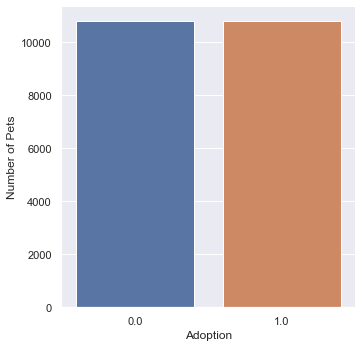

In [227]:
ax = sns.catplot(x="Adoption",data=df_processed2_b_balanced, kind='count')
(ax.set_axis_labels("Adoption", "Number of Pets"))

We can see that the oversampling was successful because we now have the same number of examples for adopted and not adopted pets, with a total of 21592 examples.

We will be using `df_processed2_b_balanced` as the **balanced, binary task general dataset**.

#### Multiclass classification - Random Over-Sampling

We can see that the oversampling was successful because we now have the same number of examples for all `AdoptionSpeed`, with a total of 20985 examples.

In [228]:
#RANDOM OVERSAMPLING
df_processed2_m = df_processed2.copy()
ros_m = RandomOverSampler(random_state=42)
X_ros_m, y_ros_m = ros_m.fit_resample(df_processed2_m.iloc[:,:-1], df_processed2_m['AdoptionSpeed'])

# y_ros_b is a np array in some versions and a pd dataframe in others. 
# An object-type check must be applied in order to further proccess the data

if ( isinstance(y_ros_b, pd.DataFrame) or isinstance(y_ros_b, pd.Series) ):
    df_processed2_m_balanced = X_ros_m.join(y_ros_m)
    
else:
    y_ros_m.shape = (20985,1) #reshape array for concatenation
    np_processed2_m_balanced = np.concatenate((X_ros_m, y_ros_m), axis=1) #save new data
    df_processed2_m_balanced = pd.DataFrame(data=np_processed2_m_balanced, columns=df_processed2_m.columns)

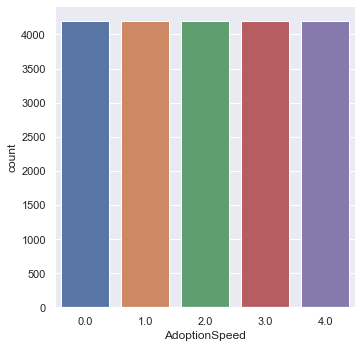

In [229]:
ax = sns.catplot(x="AdoptionSpeed",data=df_processed2_m_balanced, kind='count')

##### Dogs and Cats - preprocessing

In [230]:
# DOGS BINARY CLASSIFICATION
df_processed2_b_balanced_dogs = df_processed2_b_balanced.copy()
df_processed2_b_balanced_dogs = df_processed2_b_balanced_dogs[df_processed2_b_balanced_dogs['Type']==1]

# DOGS MULTICLASS CLASSIFICATION
df_processed2_m_balanced_dogs = df_processed2_m_balanced.copy()
df_processed2_m_balanced_dogs = df_processed2_m_balanced_dogs[df_processed2_m_balanced_dogs['Type']==1]

# CATS BINARY CLASSIFICATION
df_processed2_b_balanced_cats = df_processed2_b_balanced.copy()
df_processed2_b_balanced_cats = df_processed2_b_balanced_cats[df_processed2_b_balanced_cats['Type']==2]

# CATS MULTICLASS CLASSIFICATION
df_processed2_m_balanced_cats = df_processed2_m_balanced.copy()
df_processed2_m_balanced_cats = df_processed2_m_balanced_cats[df_processed2_m_balanced_cats['Type']==2]

### Feature encoding

Data encoding is a necessary step for categorical features. Our machine learning algorithms must receive numerical inputs, and as such, data organised in categories must be converted appropriately. We observe two distinct types of categorical features in our dataset:

1) ordinal categorical data, that is, data organised in classes which have a natural order to them;

2) nominal categorical data, that is, data organised in classes which are distinct and unordered.

Of the first kind, we observe features such as `MaturitySize`, `FurLength` and `Health`. These benefit from label encoding, also known as ordinal encoding, which converts each class to a numerical value that preserves the order in the category. However, the existence of a default value `0` for unspecified fields makes analysis of these features easier if considering them nominal data.

The remaining categorical features fit the second type. For these, one hot encoding is a good option. With this method, each class in the category becomes its own binary feature (it either exists or it doesn't in each data entry), therefore eliminating any underlying assumptions of order or distance between classes. This method tends to lose usefulness in cases of high cardinality features; tree-based models are more prone to overfit, as nodes will split in many possible values for each class in each category.

In [231]:
# This function allows the encoding of the features of a given dataset
# Inputs: 
  # df: the dataframe we want to enconde
  # enc_features: list of features we want to encode
  # nonenc_features: list of features we don't want to encode
# Output: encoded dataset

def encode(df, enc_features, nonenc_features, binary):
    encoder = OneHotEncoder()
    df_encoded = encoder.fit_transform(df[enc_features]).toarray()
    column_name = encoder.get_feature_names(enc_features)
    df_result =  pd.DataFrame(df_encoded, columns= column_name)
    
    # INSERT THE PETID AS INDEX
    df_result.insert(0,'PetID',df.index.tolist())
    df_result.set_index("PetID", inplace=True) # change index to PetId
    
    # INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
    count=2
    for i in nonenc_features:
        df_result.insert(count,i,df[i]) 
        count+=1
        
    # INSERT THE TARGET CLASS
    if binary:
        df_result.insert((len(df_result.columns)),'Adoption',df['Adoption']) ## Adoption (binary)
    else:
        df_result.insert((len(df_result.columns)),'AdoptionSpeed',df['AdoptionSpeed']) ## AdoptionSpeed
    
    return df_result

In [232]:
### ENCODING FEATURES

#df_processed1
enc_features1 = ['Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']
nenc_features1 = ['hasName','Age','DescriptionSize','Quantity','Fee','FrequentRescuer','VideoAmt','PhotoAmt']
df_processed1_encoded = encode(df_processed1, enc_features1, nenc_features1, False)
df_processed1_encoded.to_csv(r'C:\Users\david\Documents\GitHub\Machine-Learning-2019\df_processed1_m_encoded.csv', index_label='PetID')

#df_processed2_b_balanced
nenc_features2 = ['hasName','Age','DescriptionSize','Quantity','Free','FrequentRescuer','hasVideo','PhotoAmt']
df_processed2_b_balanced_encoded = encode(df_processed2_b_balanced, enc_features1, nenc_features2, True)
df_processed2_b_balanced_encoded.to_csv(r'C:\Users\david\Documents\GitHub\Machine-Learning-2019\df_processed2_b_balanced_encoded.csv', index_label='PetID')

#df_processed2_m_balanced
df_processed2_m_balanced_encoded = encode(df_processed2_m_balanced, enc_features1, nenc_features2, False)
df_processed2_m_balanced_encoded.to_csv(r'C:\Users\david\Documents\GitHub\Machine-Learning-2019\df_processed2_m_balanced_encoded.csv', index_label='PetID')

#df_processed2_b_balanced_dogs
enc_features2 = ['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']
df_processed2_b_balanced_dogs_encoded = encode(df_processed2_b_balanced_dogs, enc_features2, nenc_features2, True)

#df_processed2_b_balanced_cats
df_processed2_b_balanced_cats_encoded = encode(df_processed2_b_balanced_cats, enc_features2, nenc_features2, True)

#df_processed2_m_balanced_dogs
df_processed2_m_balanced_dogs_encoded = encode(df_processed2_m_balanced_dogs, enc_features2, nenc_features2, False)

#df_processed2_m_balanced_cats
df_processed2_m_balanced_cats_encoded = encode(df_processed2_m_balanced_cats, enc_features2, nenc_features2, False)

/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In

### Pre-processing: final dataset
We have the following dataframes to feed the classifiers in the following phase:
* Binary task: `df_processed2_b_balanced_encoded`
* Multiclass task: `df_processed2_m_balanced_encoded`
* Dogs binary task: `df_processed2_b_dogs_encoded`
* Dogs multiclass task: `df_processed2_m_dogs_encoded`
* Cats binary task: `df_processed2_b_cats_encoded`
* Cats multiclass task: `df_processed2_m_cats_encoded`

Remember the (non-encoded) features chosen for these datasets:

In [233]:
print(list(df_processed2_b_balanced.columns))

['Type', 'hasName', 'Age', 'Free', 'hasVideo', 'DescriptionSize', 'Breed2', 'Breed1', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'State', 'FrequentRescuer', 'PhotoAmt', 'Adoption']


## 1.2. Learning Classifiers

In [234]:
# creates a framework for printing confusion matrices side by side
# X for some informative string
# y_train for the training set targets
# y_train_predict for the target predictions by the model
# y_test for the test set targets 
# y_test_predict for the test predictions by the model

def confusion (X,y_train,y_train_predict,y_test,y_test_predict):
    print('{}'.format(X))
    
    cm_train = confusion_matrix(y_train, y_train_predict)
    cm_test = confusion_matrix(y_test, y_test_predict)
    
    y = np.unique(y_train)
    z = np.unique(y_test)
    
    f, ax = plt.subplots(1,2) # defines two matrix plots, one for the training set and the other for the test set
    sns.heatmap(cm_train.T, square=True, annot = True, fmt='d', cbar=False,
                xticklabels=(y),
                yticklabels=(y),
                ax=ax[0]) # first plot
    ax[0].set_xlabel('True class')
    ax[0].set_ylabel('Predicted class')
    ax[0].set_title('Confusion Matrix - Training Set')

    sns.heatmap(cm_test.T, square=True, annot = True, fmt='d', cbar=False,
                xticklabels=(z),
                yticklabels=(z),
                ax=ax[1]) # second plot
    ax[1].set_xlabel('True class')
    ax[1].set_ylabel('Predicted class')
    ax[1].set_title('Confusion Matrix - Test Set')

In [235]:
# creates a framework for model fitting, scoring and target predictions
# takes xtrain, ytrain, xtest and ytest as arguments
# the arguments xtrain, ytrain, xtest and ytest come from splitting the dataset into training and test sets
# takes the classifier (model) as argument 
# prints classification reports for both training and test sets
# returns predicted targets for both training and test sets
# returns fitting scores (accuracy) for both training and test sets

def model (intro,xtrain,ytrain,xtest,ytest,md):
    #print ("{}\n".format(intro))
    #md = model.fit(xtrain,ytrain)
    print("Accuracy on training set:\n")
    trainscore = md.score(xtrain, ytrain)
    print("{}\n".format(trainscore))
    ytrainp = md.predict(xtrain)
    print('Classification report (training):')
    print(classification_report(ytrain,ytrainp))
    print("Accuracy on test set:\n") 
    testscore = md.score(xtest, ytest)
    print("{}\n".format(testscore))
    ytestp = md.predict(xtest)
    print('Classification report (test):')
    print(classification_report(ytest,ytestp))
    return ytrainp, ytestp, trainscore, testscore

In [236]:
# separates examples from targets and optionally splits it into training and testing
def separate_split(df,split):
    nc = df.shape[1]
    matrix = df.values # Convert dataframe to darray
    examples = matrix [:, 0:nc-1] # get features 
    target = matrix [:, nc-1] # get class (last columns)           
    fnames = df.columns.values[0:nc-1] #get features names
    tname = df.columns.values[nc-1] #get target name
    examples = examples.astype(float)
    target = target.astype(float)
    if not split:
        return examples, target, fnames, tname
    else:
        X_train, X_test, y_train, y_test = train_test_split(examples, target, random_state=0)
        print("Number of examples and features for the training dataset: ", X_train.shape)
        print("Number of examples and features for the test dataset: ", X_test.shape)
        return X_train, X_test, y_train, y_test

In [237]:
# conducts k-fold cross-validation for a certain model
def crossvalidation(model,examples,target,classes):
    
    # 5-fold cross validation to return estimators and their individual scores
    scores_list = cross_validate(model,examples,target,cv=5,return_train_score=True,return_estimator=True)
    train_test_df = pd.DataFrame({'Training score': scores_list['train_score'],
                                  'Test score': scores_list['test_score']},index=list(range(5)))
    fig, ax = plt.subplots(1,2)
    sns.set_style("whitegrid")
    train_test_df.plot(x = 'Training score',
                       y = 'Test score',
                       kind = 'scatter',
                       ax = ax[0])
    
    for train, test in train_test_df.iterrows():
        ax[0].annotate(train, test)     
    ax[0].set_title('Cross-Validation Estimator Scores')
    
    # prediction for confusion matrix
    target_pred = cross_val_predict(model, examples, target, cv=5)
    conf_mat = confusion_matrix(target, target_pred,labels=classes)
    print('Test set results:')
    print(classification_report(target, target_pred))
    
    # scores for the 5 estimators
    scores = cross_val_score(model, examples, target, cv=5)
    print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
    
    # confusion matrix heatmap
    sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", ax=ax[1])
    ax[1].set_xlabel('True class')
    ax[1].set_ylabel('Predicted class')
    ax[1].set_title('Confusion Matrix - Cross-Validation')
    return target_pred, conf_mat, scores, scores_list

### 1.2.1 Benchmark
Before going into training the classifiers with our altered datasets, we want to perform a benchmark of the original dataset's performance in the models (`df_processed1_encoded`).

In [238]:
X_train, X_test, y_train, y_test = separate_split(df_processed1_encoded,True)
examples_binary, target_binary, fnames_binary, tname_binary = separate_split(df_processed1_encoded,False)

Number of examples and features for the training dataset:  (11244, 377)
Number of examples and features for the test dataset:  (3749, 377)


#### 1.2.1.1 Predicting Adoption (binary classification task)

Since this is a binary task, `AdoptionSpeed` has to be converted into a binary target class (`0` for profiles with `AdoptionSpeed = 4` and `1` for profiles with `AdoptionSpeed < 4`)

In [239]:
# This function converts an array of multiclass targets into binary classes
def binarize(table_y):
    for i in range(len(table_y)):
        if table_y[i]<4:
            table_y[i]=1
        else:
            table_y[i]=0
    return table_y

In [240]:
y_train_binary = binarize(y_train)
y_test_binary = binarize(y_test)
target_binary = binarize(target_binary)
print("Number of positives cases in the dataset is: {}".format(np.count_nonzero(target_binary == 1)))
print("Number of negative cases in the dataset is: {}".format(np.count_nonzero(target_binary == 0)))
print("Ratio of positive to negative cases in the dataset: {}".format((np.count_nonzero(target_binary == 1))/(np.count_nonzero(target_binary == 0))))

Number of positives cases in the dataset is: 10796
Number of negative cases in the dataset is: 4197
Ratio of positive to negative cases in the dataset: 2.5723135573028353


Different types of machine learning algorithms will be used to solve the task, as a way to see which will be the most appropriate. Model hyperparameters (if applicable) can be determined manually or via automatic methods, such as grid search.

In order to optimise the model, the grid search method does an exhaustive assessment of best hyperparameters for the estimator. The grid search will go through all possible hyperparameter combinations and evaluate each model using a few metrics for scoring.

5-fold cross-validation is the default model evaluation in this case. The training data is split in 5 equally-sized subsets (hence, the "5-fold"), and the model will be trained 5 times, each time leaving a different subset out, to be a test set. The performance of the model is the average of the performance over all (5) different test sets. Below, there is an image explaining the process.

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width="500">

Classification reports can be broken down in 4 columns of precision, recall, score and support:

* 1 row for each target class;
* 1 row for the overall accuracy.

Since the scoring is F1 macro:
* 1 row for macro averages;
* 1 row for weighted averages.

Overall, the pipeline consists of:

1) Initialise an estimator;

2) Fit the training data (train the model) to the estimator and test it (via test split), using k-fold cross-validation;

3) Score model using various metrics and discuss results.

In the case of grid search-applicable algorithms, k-fold cross validation is conducted to select the best estimator, and an additional k-fold cross-validation step is done to isolate its scores and results for further analysis.

##### Distance-based Models - K-Nearest Neighbours

In [241]:
## This function is a pipeline for training and testing knn models
# on binary or multiclass analysis
# args:
# binary = (boolean) whether the analysis is binary or not

def knn(examples,target,binary):
    # Initialising the estimator
    knn = neighbors.KNeighborsClassifier() # 5 neighbours by default
    
    #Grid search (hyperparameter tuning) and k-fold cross-validation fitting/scoring
    # Defining and applying a grid search cross validation to find the best hyperparameters for the knn estimator 
    # adequate metric, adequate p for the minkowski metric, adequate number of neighbours and weights
    if binary:
        knn_p = {'metric': ['minkowski','chebyshev'],
                          'p': [1,2,3,4,5],
                          'n_neighbors': [2,3,4,5,6,7], # even and odd number of neighbours
                          'weights': ['uniform','distance']}
    else:
        knn_p = {'metric': ['minkowski','chebyshev'],
                      'p': [1,2,3,4,5],
                      'n_neighbors': [2,4,6,8,10,20], 
                      'weights': ['uniform','distance']}
    
    # There are 2 * 5 * 6 * 2 = 120 different combinations of hyperparameters, meaning that the grid search 
    # will create all these different versions of the model, which are then fit to the training data. 
    # Since each model goes through 5-fold cross-validation, there are 120 * 5 = 600 fits in total.
    
    # The scoring metric for the grid searh in the benchmark task will be the score of the estimator (runs slow)
    knn_grid = GridSearchCV(knn, # creates all 120 versions of the KNN model
                            knn_p, 
                            scoring='f1_macro',
                            cv=5,
                            verbose=10,
                            n_jobs = 1) # CHANGE TO n_jobs = -1 TO USE MAXIMUM PARALLEL PROCESSES (INCREASE SPEED)
    knn_grid.fit(examples,target) # 5-fold cross-validation fitting (120 * 5 fits) for KNN models
    
    # Picking and revalidating the best estimator
    knn_best = knn_grid.best_estimator_ # assigning the parameters to the KNN estimator
    print('Best estimator:\n\n{}'.format(knn_best))
    
    # Print scores
    if binary:
        a = [0,1]
    else:
        a = [0,1,2,3,4]
        
    (y_pred_knn, 
     conf_mat_knn, 
     knn_scores, 
     knn_scores_list) = crossvalidation(knn_best,
                                        examples,
                                        target,
                                        a)

In [35]:
knn(examples_binary,target_binary,True)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.586, total=   4.0s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.587, total=   3.9s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.596, total=   4.2s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.589, total=   4.5s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.7s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.596, total=   4.1s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.8s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.608, total=   4.2s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.1s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.591, total=   4.1s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   29.2s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.605, total=   4.2s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.4s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.605, total=   4.3s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.7s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.612, total=   4.7s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.582, total=   3.1s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.570, total=   2.8s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.578, total=   3.0s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.574, total=   2.4s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.574, total=   2.3s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=2, p=2, w

[CV]  metric=minkowski, n_neighbors=3, p=2, weights=uniform, score=0.580, total=   2.6s
[CV] metric=minkowski, n_neighbors=3, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=3, p=2, weights=uniform, score=0.591, total=   2.7s
[CV] metric=minkowski, n_neighbors=3, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=3, p=2, weights=uniform, score=0.583, total=   2.6s
[CV] metric=minkowski, n_neighbors=3, p=2, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=3, p=2, weights=uniform, score=0.581, total=   3.0s
[CV] metric=minkowski, n_neighbors=3, p=2, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=3, p=2, weights=distance, score=0.597, total=   2.9s
[CV] metric=minkowski, n_neighbors=3, p=2, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=3, p=2, weights=distance, score=0.583, total=   2.4s
[CV] metric=minkowski, n_neighbors=3, p=2, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=3, p=2, 

KeyboardInterrupt: 

Running the grid search algorithm, the best hyperparameters found were the `metric = 'minkowski'` with `p = 1`, meaning distance is measured as the Manhattan distance, with 4 neighbours. Odd numbers are recommended in KNN algorithms to ensure easy majorities in neighbour classes, but it seems an even number scored highest in our selection of numbers. `weights = 'uniform'` attributes equal weight in determining class prediction to every considered neighbour.

It's clear that the algorithm is weak in predicting `Adoption=0`, suggesting the imbalance in the dataset is compromising analysis and model performance.

##### Probabilistic Models - Naïve Bayes

The Naïve Bayes algorithm has many different variations, such as:

1) *Gaussian*, best used in continuous numerical datasets (presumes a normal distribution of values);
    
2) *Multinomial*, when features represent frequency counts/number of occurrences;
    
3) *Bernoulli*, for datasets with binary categories;
    
4) *Complement*, which is designed for imbalanced datasets.

An important aspect to consider in Naïve Bayes models is the underlying assumption that all features are independent from each other.

In [242]:
## This function is a pipeline for training and testing naive bayes Bernoulli models
# on binary or multiclass analysis
# args:
# binary = (boolean) whether the analysis is binary or not

def bernoulli(examples,target,binary):
    
    # Initialising the estimator
    bnb = BernoulliNB()
    
    # Print scores
    if binary:
        a = [0,1]
    else:
        a = [0,1,2,3,4]
    
    # K-fold cross-validation fitting/scoring
    (y_pred_bnb, 
     conf_mat_bnb, 
     bnb_scores, 
     bnb_scores_list) = crossvalidation(bnb,
                                        examples,
                                        target,
                                        a)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.66      0.62      0.64     10796
         1.0       0.64      0.67      0.66     10796

    accuracy                           0.65     21592
   macro avg       0.65      0.65      0.65     21592
weighted avg       0.65      0.65      0.65     21592

Accuracy: 0.65 (+/- 0.02)


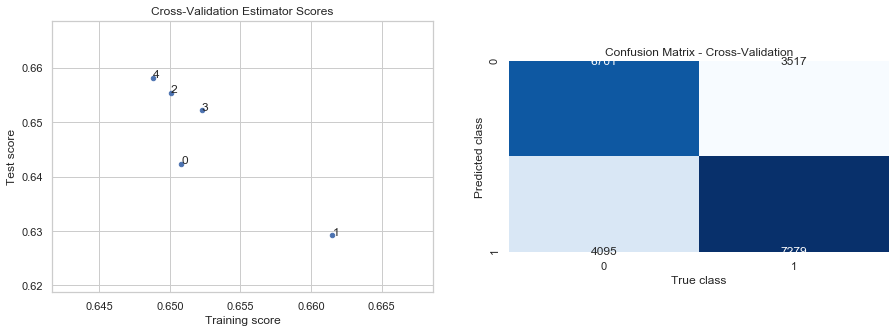

In [269]:
bernoulli(examples_binary,target_binary,True)

The benchmark tests of Bernoulli Naïve Bayes reveal the following points: prediction of `Adoption=0` is very weak in comparison to `Adoption=1`, most likely due to the imbalance in the used dataset (F1 score of 0.45 and a clearly high number of false `Adoption=1` predictions).

##### Tree Models - Decision Tree

In [243]:
# This function is a pipeline for training and testing tree models
# on binary or multiclass analysis
# args:
# binary = (boolean) whether the analysis is binary or not
# tree_vis = (boolean) whether we want to output a visual representation of the tree

def decision_tree (examples, target, binary, tree_vis, fnames):
    
    # Initialising the estimator
    dec_tree = tree.DecisionTreeClassifier()
    
    # Grid search (hyperparameter tuning) and k-fold cross-validation fitting/scoring
    # The grid search will test the Gini index criterion versus the information gain criterion.
    if binary:
        dec_tree_p = {'criterion': ['gini','entropy']}
    else:
        dec_tree_p  ={'class_weight':[None,'balanced'],
                             'criterion':['gini','entropy'],
                             'max_features':[None,'auto','log2'],
                             'min_samples_leaf':[1,2,3,4,5,6],
                             'min_samples_split':[2,3,4,5]}

    dec_tree_grid = GridSearchCV(dec_tree, 
                                dec_tree_p, 
                                scoring='f1_macro',
                                cv=5,
                                n_jobs = 1) # creates all 2 versions of the decision tree model

    dec_tree_grid.fit(examples,target)

    # Picking and revalidating the best estimator
    # assigning the parameters to the decision tree estimator
    dec_tree_best = dec_tree_grid.best_estimator_ 
    print('Best estimator:\n\n{}'.format(dec_tree_best))

    # Print scores
    if binary:
        a = [0,1]
    else:
        a = [0,1,2,3,4]
    
    (y_pred_dec_tree, 
    conf_mat_dec_tree, 
    dec_tree_scores, 
    dec_tree_scores_list) = crossvalidation(dec_tree_best,
                                            examples,
                                            target,
                                            a)
    if tree_vis:
        dot_data = tree.export_graphviz(dec_tree_best, 
                                        feature_names = fnames,
                                        out_file = None,
                                        filled = True, 
                                        rounded = True,
                                        special_characters = True)

        graph = pydotplus.graph_from_dot_data(dot_data)
        Image(graph.create_png())

In [ ]:
decision_tree(examples_binary, target_binary, True, True, fnames_binary)

We can see the decision tree model is highly complex. This is an expected result, as one hot encoding creates many binary features, which lead to large decision trees that split in many different ways. The best feature according to this model was `Age`.

##### Linear Models - Support Vector Machines

In [272]:
# This function is a pipeline for training and testing linear SVM
# on binary or multiclass analysis
# args:
# binary = (boolean) whether the analysis is binary or not

def lsvm(examples, target, binary):
    
    # Initialising the estimator
    lsvm = LinearSVC(max_iter = 15000, dual = False) # max_iter=1000 (default) didn't converge: dual = False recommended for large datasets
    
    # Grid search (hyperparameter tuning) and k-fold cross-validation fitting/scoring
    if(binary):
        lsvm_p = {'penalty': ['l1','l2']}
    else:
        lsvm_p =  {'C':[0.0001,0.001,0.01,0.1,1,10,100],
                'class_weight':[None,'balanced'],
                'max_iter':[10000],
                'penalty':['l1','l2']}
        
    lsvm_grid = GridSearchCV(lsvm, 
                             lsvm_p, 
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs = 1) # creates all 2 versions of the decision tree model
    
    lsvm_grid.fit(examples,target)
    
    # Picking and revalidating the best estimator
    lsvm_best = lsvm_grid.best_estimator_ # assigning the parameters to the linear SVM estimator
    print('Best estimator:\n\n{}'.format(lsvm_best))
    
    # Print scores
    if binary:
        a = [0,1]
    else:
        a = [0,1,2,3,4]
    
    (y_pred_lsvm, 
     conf_mat_lsvm, 
     lsvm_scores, 
     lsvm_scores_list) = crossvalidation(lsvm_best,
                                        examples,
                                        target,
                                        a)
    

In [ ]:
lsvm(examples_binary, target_binary, True)

The linear model's performance may have benefitted from one hot encoding, seeing as though most examples can only occupy two possible coordinates in each of their spacial dimensions (features) and that could ease linear separability.

The imbalance remains a problem to address, given poor accuracy in prediction of `Adoption=0`.

* ***Rule Models - CN2 Rule Induction***

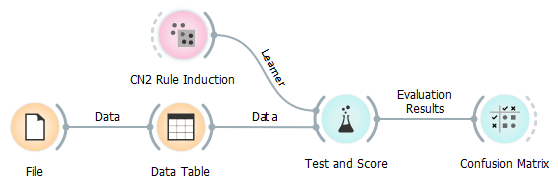

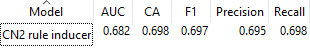

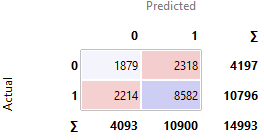

The file used is the *.csv* equivalent to the `df_processed_1_encoded` dataset.
*Test and Score* parameters were set for 5-fold stratified cross-validation (the same as the cross-validation functions used in the remaining models).

Similarly to all previous models, rule modelling displays poor minority class prediction accuracy.

#### Overall conclusions

Assuming the models are in fact learning correctly, the most evident problem in the dataset is the imbalance. However, it's also *very likely the models are not learning appropriately at all*.

Given that we have approximately a 2.6 : 1 ratio of `Adoption=1` to `Adoption=0`, even if the models were always guessing `Adoption=1`, they would still be 2.6 times more likely to guess right and inflate accuracy results, meaning the model is ignoring the minority class and getting good scores based on the poorly prepared dataset.

#### 1.2.1.2 Predicting AdoptionSpeed (multiclass classification task) 

In [ ]:
examples_bench_multi, target_bench_multi, fnames_bench_multi, tname_bench_multi = separate_split(df_processed1_encoded,False)

In [ ]:
print("Number of Adoption=0 examples in the dataset: {}".format(np.count_nonzero(target_bench_multi == 0)))
print("Number of Adoption=1 examples in the dataset: {}".format(np.count_nonzero(target_bench_multi == 1)))
print("Number of Adoption=2 examples in the dataset: {}".format(np.count_nonzero(target_bench_multi == 2)))
print("Number of Adoption=3 examples in the dataset: {}".format(np.count_nonzero(target_bench_multi == 3)))
print("Number of Adoption=4 examples in the dataset: {}".format(np.count_nonzero(target_bench_multi == 4)))
print("Ratio of least representative class to most representative class in the dataset: {}".format((np.count_nonzero(target_bench_multi == 0))/(np.count_nonzero(target_bench_multi == 4))))

##### Distance-based Models - K-Nearest Neighbours

In [ ]:
knn(examples_bench_multi,target_bench_multi,False)

Given the imbalanced dataset and using GridSearchCV to find the best possible hyperparameters parameters for the K-Nearest Neighbours algorithm, it was found that 4 neighbours and a minkowski distance of p=1 (Manhattan) were the best possible hyperparameters for an f1_macro scoring metric.
The results on the minority class are very poor not only regarding precision but also the ability to identify correctly the relevant examples (recall). 

The class imbalance seems to be having a great influence on the model's ability to lear the minority class. The most representative classes show a somewhat increasing performance with increasing number of learning examples and a similar performance regarding precision and recall.

The most representative class (adoptionspeed=4) is the one in which this model shows better performance both regarding precision and recall.

The overall performance of this model is compromised by the low performance on the minority class which hints that balancing the dataset will probably provide better results. 

It also seems clear that the model is overfitting the dataset since training scores are generally 3 times higher than the test set scores for the same model.

##### Probabilistic Models - Naïve Bayes

In [ ]:
bernoulli(examples_bench_multi,target_bench_multi,False)

For each fold the performance on the training set is similar to the one on the test set and around 0.36/0.37. This clearly suggests the model is underfitting the data. 

Performance on the minority class is very poor even when compared with the performance of the model on the other classes, with few examples being correctly classified. 

The most representative class (adoptionspeed=4) is the one in which this model shows better performance both regarding precision and recall.

The poor performance on the minority class is also degrading the overall performance of the model.

##### Tree Models - Decision Trees

In [ ]:
decision_tree(examples_bench_multi, target_bench_multi, False, True, fnames_bench_multi)

Given the imbalanced dataset and using GridSearchCV to find the best possible hyperparameters for the Decision Tree, it was found that a minimum number of samples required for a split of 2, a minimum number of samples required to be at a leaf node of 1 and a entropy measure, to be optimal regarding a f1_macro scoring metric.

The most representative class (adoptionspeed=4) is the one in which this model shows better performance both regarding precision and recall.

The overall performance of this model is compromised by the low performance on the minority class which hints that balancing the dataset will provide better results. 

It also seems clear that the model is overfitting the dataset since training scores are generally 3 times higher than the test set scores for the same model.

##### Linear Models  - Support Vector Machines

In [ ]:
lsvm(examples_bench_multi,target_bench_multi,False)

Given the imbalanced dataset and using GridSearchCV to find the best possible hyperparameters for the Linear Support Vector Machine, it was found that a regularization parameter (C) of 0.1 and a l2 penalty norm were optimal, despite de inability of the algoritm to converge, despite the high number of iterations 10000. This might suggest that the data is not entirely linearly separable and that using a kernell algoritm would increase performance, or at least converge towards a solution.

The most representative class (adoptionspeed=4) is the one in which this model shows better performance both regarding precision and recall.

The overall performance of this model is compromised by the low performance on the minority class which hints that balancing the dataset will provide better results. 

Its also seems clear that the model is underfitting the dataset.

##### Rule Models

##### Benchmark conclusions

Both Decision trees and K-Nearest Neighbours provided almost perfect results on the training sets but performed considerably worst on the test set. Both these models seem to be overfitting the training examples and failing to generalize over unseen examples. On the other hand, both Linear Support Vector Machines and Bernoulli Naive Bayes show considerable underfitting of the data with training scores below 0.40. 

Regarding individiual class performances none of the models showed great ability to provide the minority class (adoptionspeed=0) which underlines the need of oversampling the dataset to provide the algorithms with stronger evidence of that class. 

From all the tested approaches, the Bernoulli Naive Bayes model was the one that showcased better results in both AdoptionSpeed=1 and Linear Support Vector Machines the best for AdoptionSpeed=4 classes with higher precision and recall scores. On the other hand the K-Nearest Neighbours model performed better in both AdoptionSpeed=2 and AdoptionSpeed=3.

All the models showcase similar low overall performance.

## 1.2.2 Predicting Adoption (binary classification task)

Using the dataset `df_processed2_b_balanced_encoded` (binary target, balanced examples and encoded features), we will run the same algorithms as in the previous section, **1.2.1.**

In [262]:
X_train, X_test, y_train, y_test = separate_split(df_processed2_b_balanced_encoded,True)
examples_binary, target_binary, fnames_binary, tname_binary = separate_split(df_processed2_b_balanced_encoded,False)

Number of examples and features for the training dataset:  (16194, 377)
Number of examples and features for the test dataset:  (5398, 377)


In [263]:
print("Number of positives cases in the dataset is: {}".format(np.count_nonzero(target_binary == 1)))
print("Number of negative cases in the dataset is: {}".format(np.count_nonzero(target_binary == 0)))
print("Ratio of positive to negative cases in the dataset: {}".format((np.count_nonzero(target_binary == 1))/(np.count_nonzero(target_binary == 0))))

Number of positives cases in the dataset is: 10796
Number of negative cases in the dataset is: 10796
Ratio of positive to negative cases in the dataset: 1.0


##### Distance-based Models - K-Nearest Neighbours

In [ ]:
knn(examples_binary, target_binary,True)

The grid search algorithm has returned a different set of hyperparameters, with `n_neighbors` reduced to `2`. This might be related to the oversampling of the minority class. With rarer occurences of the minority class, the benchmark model might have had to increase the number of neighbours to increase the odds of finding `Adoption=0` and therefore improve prediction. The random oversampling ensures a greater number of negative cases in the overall landscape, driving the number of neighbours to decrease. The distance measure is now Euclidian (`p = 2`), and `weights` takes distance into consideration (possibly because with only two neighbours, using distance is more effective for breaking ties which become more often).

The results have improved significantly from the benchmark tests. Both training and test accuracies have improved, as well as prediction of both classes. The most significant increase was for prediction of `Adoption=0`, for which prediction accuracy almost doubled, once again suggesting oversampling the dataset was a good choice. 

##### Probabilistic Models - Bernoulli Naïve Bayes

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.66      0.62      0.64     10796
         1.0       0.64      0.67      0.66     10796

    accuracy                           0.65     21592
   macro avg       0.65      0.65      0.65     21592
weighted avg       0.65      0.65      0.65     21592

Accuracy: 0.65 (+/- 0.02)


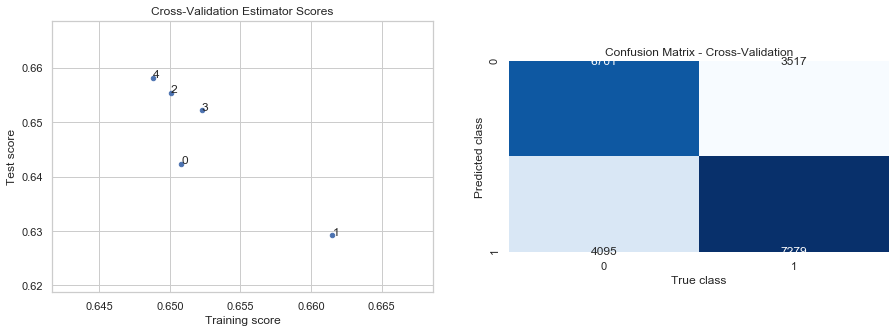

In [270]:
bernoulli(examples_binary, target_binary,True)

Overall accuracy was reduced considerably (from ~72% to ~65%). This can be seen in the noticeable decrease in performance for prediction of `Adoption=1`. However, as a positive point, this version of the model is significantly better at predicting `Adoption=0` (an F1 score increase of 0.19, from 0.45 to 0.64). It is also much more even in the prediction success in both classes, whereas the previous one showed a significant discrepancy in prediction of the minority class. We can see that oversampling was a good option for this dataset to mitigate minority class problems.

Perhaps a probabilistic model is not suited to this dataset, as the exploratory data analysis revealed very few correlations between features (and, therefore, pet profiles) and odds of adoption.

***Tree Models - Decision Tree***

Best estimator:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87     10796
         1.0       0.94      0.76      0.84     10796

    accuracy                           0.86     21592
   macro avg       0.87      0.86      0.86     21592
weighted avg       0.87      0.86      0.86     21592

Accuracy: 0.86 (+/- 0.06)


InvocationException: GraphViz's executables not found

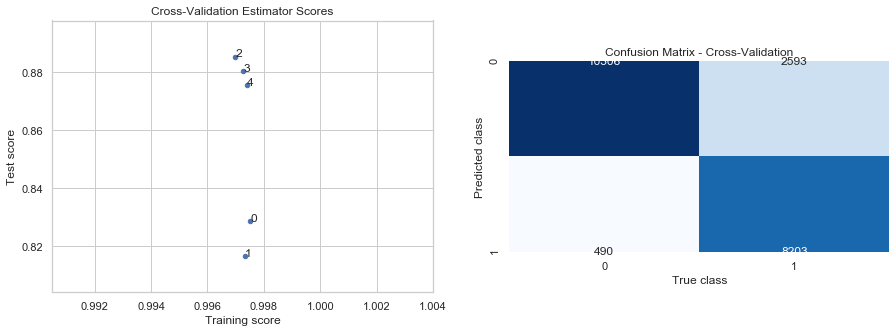

In [264]:
decision_tree(examples_binary,target_binary,True,True,fnames_binary)

***Linear Models - Support Vector Machines***

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] penalty=l1 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... penalty=l1, score=0.695, total=   5.1s
[CV] penalty=l1 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] .......................... penalty=l1, score=0.668, total=   6.9s
[CV] penalty=l1 ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s


[CV] .......................... penalty=l1, score=0.698, total=   6.5s
[CV] penalty=l1 ......................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.4s remaining:    0.0s


[CV] .......................... penalty=l1, score=0.688, total=   4.9s
[CV] penalty=l1 ......................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.3s remaining:    0.0s


[CV] .......................... penalty=l1, score=0.697, total=   7.0s
[CV] penalty=l2 ......................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.3s remaining:    0.0s


[CV] .......................... penalty=l2, score=0.696, total=   1.5s
[CV] penalty=l2 ......................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.9s remaining:    0.0s


[CV] .......................... penalty=l2, score=0.667, total=   1.1s
[CV] penalty=l2 ......................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV] .......................... penalty=l2, score=0.698, total=   1.3s
[CV] penalty=l2 ......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   34.3s remaining:    0.0s


[CV] .......................... penalty=l2, score=0.690, total=   1.3s
[CV] penalty=l2 ......................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   35.6s remaining:    0.0s


[CV] .......................... penalty=l2, score=0.697, total=   1.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.1s finished


Best estimator:

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=15000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.70      0.67      0.68     10796
         1.0       0.68      0.71      0.70     10796

    accuracy                           0.69     21592
   macro avg       0.69      0.69      0.69     21592
weighted avg       0.69      0.69      0.69     21592

Accuracy: 0.69 (+/- 0.02)


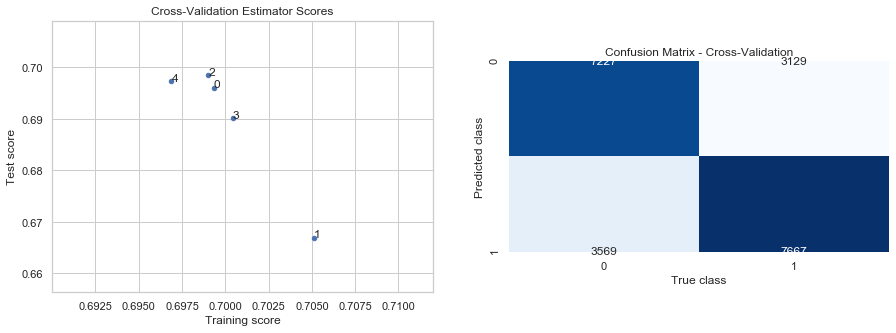

In [273]:
lsvm(examples_binary, target_binary,True)

#### Overall conclusions

## 1.2.3 Predicting Adoption Speed (Multiclass classification task)

Using the dataset `df_processed2_m_balanced_encoded` (multiclass target, balanced examples and encoded features), we will run the same algorithms as in the previous section, **1.2.1.**

In [258]:
examples_multi, target_multi, fnames_multi, tname_multi = separate_split(df_processed2_m_balanced_encoded,False)

In [259]:
print("Number of Adoption=0 examples in the dataset: {}".format(np.count_nonzero(target_multi == 0)))
print("Number of Adoption=1 examples in the dataset: {}".format(np.count_nonzero(target_multi == 1)))
print("Number of Adoption=2 examples in the dataset: {}".format(np.count_nonzero(target_multi == 2)))
print("Number of Adoption=3 examples in the dataset: {}".format(np.count_nonzero(target_multi == 3)))
print("Number of Adoption=4 examples in the dataset: {}".format(np.count_nonzero(target_multi == 4)))

Number of Adoption=0 examples in the dataset: 4197
Number of Adoption=1 examples in the dataset: 4197
Number of Adoption=2 examples in the dataset: 4197
Number of Adoption=3 examples in the dataset: 4197
Number of Adoption=4 examples in the dataset: 4197


##### ***Distance-based Models - K-Nearest Neighbours***

In [260]:
knn(examples_multi, target_multi,False)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

When Compared to the results for the K-Neighbours used on the benchmark section for the multiclass task, and as expected, the results on the former minority class (AdoptionSpeed = 0) greatly improved with an almost perfect score in that particular class. 

However, this results may be somewhat a consequence of the oversampling made (all the examples on the `AdoptionSpeed` = 0  class where theoretically replicated 10x times) which granted the existence of many of the same examples closer together in both the training and test sets. This is confirmed by the reduction from 4 to 2, on the number of neighbours considered by gridsearchcv to be optimal.

Despite the overall improvement the model still seems to be slightly overfitting the data from the other classes as it fails to properly generalise. This lack of generalisation affects the overall performance of the model.

##### ***Probabilistic Models - Naïve Bayes***

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.41      0.47      0.44      4197
         1.0       0.29      0.34      0.31      4197
         2.0       0.27      0.15      0.20      4197
         3.0       0.31      0.33      0.32      4197
         4.0       0.39      0.42      0.40      4197

    accuracy                           0.34     20985
   macro avg       0.33      0.34      0.33     20985
weighted avg       0.33      0.34      0.33     20985

Accuracy: 0.34 (+/- 0.01)


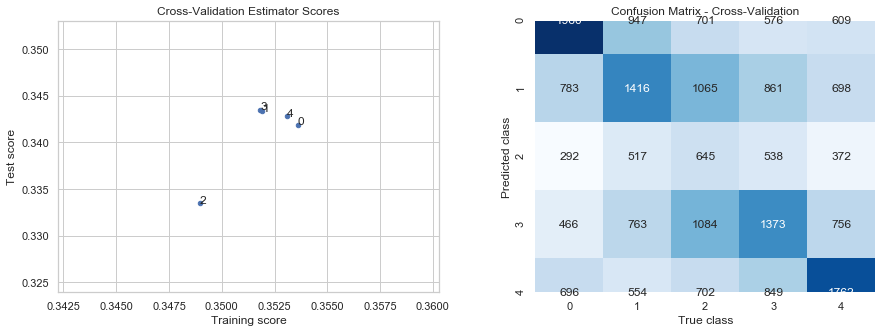

In [274]:
bernoulli(examples_multi, target_multi,False)

The Bernoulli Naive Bayes on the balanced dataset show slightly worse overall results (0.36 on the imbalanced set vs 0.34 on the balanced one).

The performance on the other classes aside from `AdoptionSpeed`=0 and `AdoptionSpeed`=3 has decreased, which might indicate that either this model is not the most approriate for this balanced task or that the chosen approaches (including feature extractions) were not the most suitable to take the best out of the model.

Other relevant information is that the model still underfits the training data.

##### ***Tree Models - Decision Tree***

/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best estimator:

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      4197
         1.0       0.56      0.62      0.59      4197
         2.0       0.40      0.35      0.37      4197
         3.0       0.53      0.57      0.55      4197
         4.0       0.51      0.43      0.46      4197

    accuracy                           0.59     20985
   macro avg       0.58      0.59      0.58     20985
weighted avg       0.58      0.59      0.58     20985

Accuracy: 0.59 (+/- 0.17)


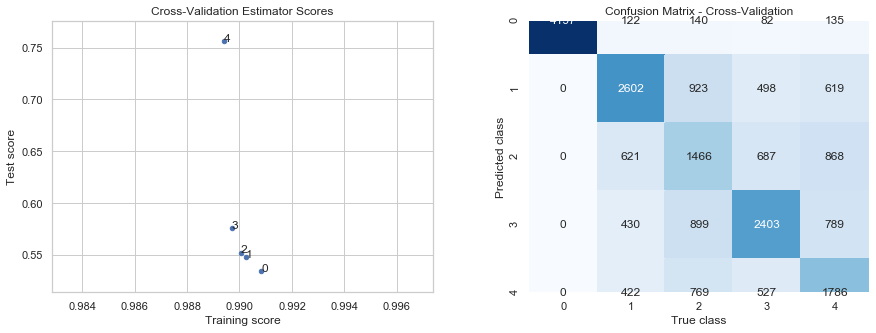

In [261]:
decision_tree(examples_multi,target_multi,False,False,fnames_multi)

When Compared to the results for the Decision Tree used on the benchmark section for the multiclass task, and as somewhat expected, the performance across different classes improved, specially for `AdoptionSpeed`=0.

Despite the overall improvement the model still seems to be overfitting the data from the all classes besides AdoptionSpeed=0 as it fails to properly generalise.

This model shows similar overall results as the K-Nearest Neighbours.

##### ***Linear Models***

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l1 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l1, score=0.154, total=   0.3s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l1, score=0.152, total=   0.3s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l1, score=0.161, total=   0.3s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l1, score=0.157, total=   0.2s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l1, score=0.153, total=   0.2s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l2 .........
[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l2, score=0.321, total=   0.6s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l2 .........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l2, score=0.329, total=   0.6s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l2 .........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.5s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l2, score=0.329, total=   0.6s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l2 .........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.1s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l2, score=0.327, total=   0.6s
[CV] C=0.0001, class_weight=None, max_iter=10000, penalty=l2 .........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.7s remaining:    0.0s


[CV]  C=0.0001, class_weight=None, max_iter=10000, penalty=l2, score=0.315, total=   0.7s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1 .....


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1, score=0.154, total=   0.2s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1 .....


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1, score=0.152, total=   0.3s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1 .....


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1, score=0.161, total=   0.2s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1 .....


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1, score=0.157, total=   0.2s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1 .....


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l1, score=0.153, total=   0.3s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2 .....
[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2, score=0.321, total=   0.7s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2 .....
[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2, score=0.329, total=   0.6s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2 .....
[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2, score=0.329, total=   0.6s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2 .....
[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2, score=0.327, total=   0.9s
[CV] C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2 .....
[CV]  C=0.0001, class_weight=balanced, max_iter=10000, penalty=l2, score=0.315, total=   0.6s
[CV] C=0.001, class_weight=None, max_iter=10000, penalty=l1 ..........
[CV]  C=0.

[CV]  C=0.1, class_weight=None, max_iter=10000, penalty=l2, score=0.353, total=   3.3s
[CV] C=0.1, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=0.1, class_weight=None, max_iter=10000, penalty=l2, score=0.355, total=   3.6s
[CV] C=0.1, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=0.1, class_weight=None, max_iter=10000, penalty=l2, score=0.351, total=   3.6s
[CV] C=0.1, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=0.1, class_weight=None, max_iter=10000, penalty=l2, score=0.351, total=   3.5s
[CV] C=0.1, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=0.1, class_weight=None, max_iter=10000, penalty=l2, score=0.363, total=   4.2s
[CV] C=0.1, class_weight=balanced, max_iter=10000, penalty=l1 ........
[CV]  C=0.1, class_weight=balanced, max_iter=10000, penalty=l1, score=0.347, total=  11.5s
[CV] C=0.1, class_weight=balanced, max_iter=10000, penalty=l1 ........
[CV]  C=0.1, class_weight=balanced, max_iter=100

/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=None, max_iter=10000, penalty=l1, score=0.354, total= 1.1min
[CV] C=1, class_weight=None, max_iter=10000, penalty=l1 ..............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=None, max_iter=10000, penalty=l1, score=0.354, total= 1.3min
[CV] C=1, class_weight=None, max_iter=10000, penalty=l1 ..............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=None, max_iter=10000, penalty=l1, score=0.352, total= 1.2min
[CV] C=1, class_weight=None, max_iter=10000, penalty=l1 ..............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=None, max_iter=10000, penalty=l1, score=0.351, total= 1.1min
[CV] C=1, class_weight=None, max_iter=10000, penalty=l1 ..............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=None, max_iter=10000, penalty=l1, score=0.362, total= 1.1min
[CV] C=1, class_weight=None, max_iter=10000, penalty=l2 ..............
[CV]  C=1, class_weight=None, max_iter=10000, penalty=l2, score=0.353, total=   7.2s
[CV] C=1, class_weight=None, max_iter=10000, penalty=l2 ..............
[CV]  C=1, class_weight=None, max_iter=10000, penalty=l2, score=0.354, total=   6.9s
[CV] C=1, class_weight=None, max_iter=10000, penalty=l2 ..............
[CV]  C=1, class_weight=None, max_iter=10000, penalty=l2, score=0.354, total=   7.0s
[CV] C=1, class_weight=None, max_iter=10000, penalty=l2 ..............
[CV]  C=1, class_weight=None, max_iter=10000, penalty=l2, score=0.351, total=   7.1s
[CV] C=1, class_weight=None, max_iter=10000, penalty=l2 ..............
[CV]  C=1, class_weight=None, max_iter=10000, penalty=l2, score=0.365, total=   8.0s
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l1 ..........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l1, score=0.355, total=  57.6s
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l1 ..........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l1, score=0.355, total= 1.2min
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l1 ..........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l1, score=0.353, total= 1.1min
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l1 ..........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l1, score=0.351, total= 1.2min
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l1 ..........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l1, score=0.364, total= 1.0min
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l2 ..........
[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l2, score=0.353, total=   6.1s
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l2 ..........
[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l2, score=0.354, total=   6.5s
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l2 ..........
[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l2, score=0.354, total=   8.7s
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l2 ..........
[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l2, score=0.351, total=   7.5s
[CV] C=1, class_weight=balanced, max_iter=10000, penalty=l2 ..........
[CV]  C=1, class_weight=balanced, max_iter=10000, penalty=l2, score=0.365, total=   8.2s
[CV] C=10, class_weight=None, max_iter=10000, penalty=l1 .............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=None, max_iter=10000, penalty=l1, score=0.352, total= 1.3min
[CV] C=10, class_weight=None, max_iter=10000, penalty=l1 .............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=None, max_iter=10000, penalty=l1, score=0.354, total= 1.4min
[CV] C=10, class_weight=None, max_iter=10000, penalty=l1 .............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=None, max_iter=10000, penalty=l1, score=0.354, total= 1.3min
[CV] C=10, class_weight=None, max_iter=10000, penalty=l1 .............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=None, max_iter=10000, penalty=l1, score=0.351, total= 1.2min
[CV] C=10, class_weight=None, max_iter=10000, penalty=l1 .............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=None, max_iter=10000, penalty=l1, score=0.365, total= 1.4min
[CV] C=10, class_weight=None, max_iter=10000, penalty=l2 .............
[CV]  C=10, class_weight=None, max_iter=10000, penalty=l2, score=0.353, total=  13.7s
[CV] C=10, class_weight=None, max_iter=10000, penalty=l2 .............
[CV]  C=10, class_weight=None, max_iter=10000, penalty=l2, score=0.354, total=  14.1s
[CV] C=10, class_weight=None, max_iter=10000, penalty=l2 .............
[CV]  C=10, class_weight=None, max_iter=10000, penalty=l2, score=0.354, total=  16.2s
[CV] C=10, class_weight=None, max_iter=10000, penalty=l2 .............
[CV]  C=10, class_weight=None, max_iter=10000, penalty=l2, score=0.350, total=  11.5s
[CV] C=10, class_weight=None, max_iter=10000, penalty=l2 .............
[CV]  C=10, class_weight=None, max_iter=10000, penalty=l2, score=0.365, total=  13.5s
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l1, score=0.353, total= 1.3min
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l1, score=0.353, total= 1.3min
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l1, score=0.353, total= 1.2min
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l1, score=0.350, total= 1.4min
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l1 .........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l1, score=0.365, total= 1.4min
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l2 .........
[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l2, score=0.353, total=  13.1s
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l2 .........
[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l2, score=0.354, total=  11.6s
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l2 .........
[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l2, score=0.354, total=  11.5s
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l2 .........
[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l2, score=0.350, total=  10.6s
[CV] C=10, class_weight=balanced, max_iter=10000, penalty=l2 .........
[CV]  C=10, class_weight=balanced, max_iter=10000, penalty=l2, score=0.365, total=  12.5s
[CV] C=100, class_weight=None, max_iter=10000, penalty=l1 ............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=None, max_iter=10000, penalty=l1, score=0.351, total= 1.1min
[CV] C=100, class_weight=None, max_iter=10000, penalty=l1 ............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=None, max_iter=10000, penalty=l1, score=0.354, total= 1.1min
[CV] C=100, class_weight=None, max_iter=10000, penalty=l1 ............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=None, max_iter=10000, penalty=l1, score=0.354, total= 1.1min
[CV] C=100, class_weight=None, max_iter=10000, penalty=l1 ............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=None, max_iter=10000, penalty=l1, score=0.350, total= 1.2min
[CV] C=100, class_weight=None, max_iter=10000, penalty=l1 ............


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=None, max_iter=10000, penalty=l1, score=0.365, total=  54.6s
[CV] C=100, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=100, class_weight=None, max_iter=10000, penalty=l2, score=0.351, total=  10.4s
[CV] C=100, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=100, class_weight=None, max_iter=10000, penalty=l2, score=0.354, total=  11.0s
[CV] C=100, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=100, class_weight=None, max_iter=10000, penalty=l2, score=0.354, total=  14.0s
[CV] C=100, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=100, class_weight=None, max_iter=10000, penalty=l2, score=0.350, total=  11.6s
[CV] C=100, class_weight=None, max_iter=10000, penalty=l2 ............
[CV]  C=100, class_weight=None, max_iter=10000, penalty=l2, score=0.364, total=  12.2s
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l1 ........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l1, score=0.351, total= 1.1min
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l1 ........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l1, score=0.354, total=  48.2s
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l1 ........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l1, score=0.354, total= 1.2min
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l1 ........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l1, score=0.350, total= 1.2min
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l1 ........


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l1, score=0.365, total= 1.3min
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l2 ........
[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l2, score=0.351, total=  11.5s
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l2 ........
[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l2, score=0.354, total=  11.9s
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l2 ........
[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l2, score=0.354, total=  13.6s
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l2 ........
[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l2, score=0.350, total=  10.7s
[CV] C=100, class_weight=balanced, max_iter=10000, penalty=l2 ........
[CV]  C=100, class_weight=balanced, max_iter=10000, penalty=l2, score=0.364, total=  12.2s


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 44.9min finished
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best estimator:

LinearSVC(C=1, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)


/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

Test set results:
              precision    recall  f1-score   support

         0.0       0.44      0.52      0.48      4197
         1.0       0.32      0.30      0.31      4197
         2.0       0.28      0.17      0.21      4197
         3.0       0.34      0.30      0.32      4197
         4.0       0.39      0.55      0.46      4197

    accuracy                           0.37     20985
   macro avg       0.35      0.37      0.35     20985
weighted avg       0.35      0.37      0.35     20985



/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/air/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

Accuracy: 0.37 (+/- 0.01)


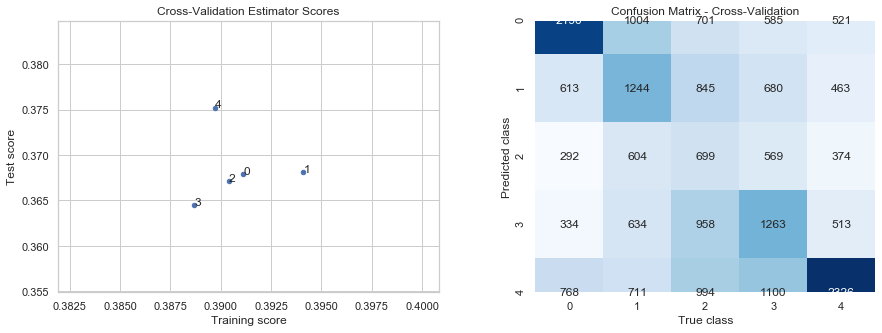

In [275]:
lsvm(examples_multi,target_multi,False)

The Linear Support Vector Machines on the balanced dataset shows the same global performance (0.36) but worse performance in all classes besides`AdoptionSpeed`=0, which greatly improved, and `AdoptionSpeed`=3, which slightly improved. This might indicate that either this model is not the most approriate for this balanced task or that the chosen approach was not the most suitable to take the best out of the model.

Other relevant information is that the model still underfits the training data and that convergence wasn't achieved despite the high number of interations.

##### Rule Models

##### ***Multi class classification - Conclusions***

## 1.2.4 Predicting Adoption/Adoption Speed for dogs

For this pet-type-specific analysis we will only test the classification model that had the best performance on the previous tasks, namely decision trees.

As stated in the EDA, the number of examples of cats and dogs is fairly proportional, as well as their relative distribution among target classes.
Thus, we will be using the previous balanced datasets, only now filtering for `Type`=1 or `Type`=2.

### Binary Classification

In [249]:
X_train_b_dogs, X_test_b_dogs, y_train_b_dogs, y_test_b_dogs = separate_split(df_processed2_b_balanced_dogs_encoded,True)
examples_b_dogs, target_b_dogs, fnames_b_dogs, tname_b_dogs = separate_split(df_processed2_b_balanced_dogs_encoded,False)

Number of examples and features for the training dataset:  (8922, 264)
Number of examples and features for the test dataset:  (2975, 264)


In [248]:
print("Number of positives cases in the dataset is: {}".format(np.count_nonzero(target_b_dogs == 1)))
print("Number of negative cases in the dataset is: {}".format(np.count_nonzero(target_b_dogs == 0)))
print("Ratio of positive to negative cases in the dataset: {}".format((np.count_nonzero(target_b_dogs == 1))/(np.count_nonzero(target_b_dogs == 0))))

Number of positives cases in the dataset is: 5718
Number of negative cases in the dataset is: 6179
Ratio of positive to negative cases in the dataset: 0.9253924583265901


As we expected, the dogs-specific dataset is balanced.

***Tree Models - Decision Tree***

Best estimator:

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88      6179
         1.0       0.94      0.76      0.84      5718

    accuracy                           0.86     11897
   macro avg       0.88      0.86      0.86     11897
weighted avg       0.87      0.86      0.86     11897

Accuracy: 0.86 (+/- 0.05)


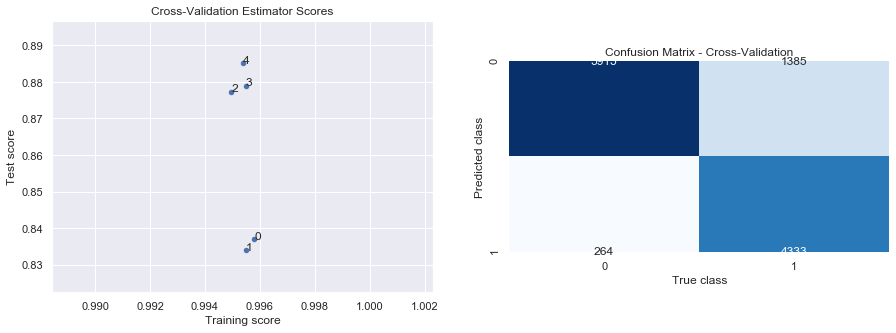

In [250]:
decision_tree(examples_b_dogs,target_b_dogs,True,False,fnames_b_dogs)

We conclude that the results for the dogs' dataset were very similar (almost the same) to the dataset containing both types of pets, in terms of precision, recall, accuracy and F1 score. The overall performance is very satisfatory, being the model able to clearly predict Adoption and non-Adoption. However, it is a bit prone to overfitting as it could not generalise enough to determine all test examples' class correctly. 

### Multiclass Classification

In [ ]:
examples_m_dogs, target_m_dogs, fnames_m_dogs, tname_m_dogs = separate_split(df_processed2_m_balanced_dogs_encoded,False)

In [267]:
print("Number of Adoption=0 examples in the dataset: {}".format(np.count_nonzero(target_m_dogs == 0)))
print("Number of Adoption=1 examples in the dataset: {}".format(np.count_nonzero(target_m_dogs == 1)))
print("Number of Adoption=2 examples in the dataset: {}".format(np.count_nonzero(target_m_dogs == 2)))
print("Number of Adoption=3 examples in the dataset: {}".format(np.count_nonzero(target_m_dogs == 3)))
print("Number of Adoption=4 examples in the dataset: {}".format(np.count_nonzero(target_m_dogs == 4)))

Number of Adoption=0 examples in the dataset: 1718
Number of Adoption=1 examples in the dataset: 1927
Number of Adoption=2 examples in the dataset: 2243
Number of Adoption=3 examples in the dataset: 2465
Number of Adoption=4 examples in the dataset: 2414


This dataset is not as balanced as the binary nor the non-type-specific ones. Either way we will carry on with the analysis, since applying another step of oversampling could distort the results.

Best estimator:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      1718
         1.0       0.55      0.63      0.58      1927
         2.0       0.41      0.36      0.38      2243
         3.0       0.54      0.58      0.56      2465
         4.0       0.55      0.46      0.50      2414

    accuracy                           0.58     10767
   macro avg       0.59      0.61      0.60     10767
weighted avg       0.57      0.58      0.58     10767

Accuracy: 0.58 (+/- 0.17)


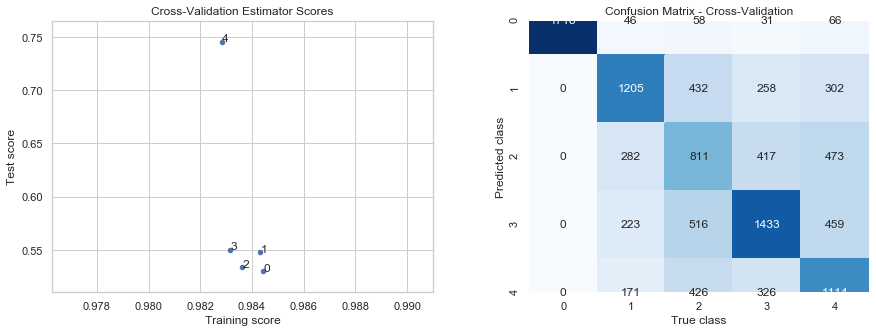

In [253]:
decision_tree(examples_m_dogs, target_m_dogs,False,False,fnames_m_dogs)

We can conclude that precision, recall and f1-score were very high for `AdoptionSpeed`=0, comparing to the other target classes. In fact, the model presented perfect recall for `AdoptionSpeed`=0, meaning that all dogs that were to be adopted on the same day could be correctly identified. This is curious, given that `AdoptionSpeed`=0 had the fewer learning examples out of all target classes.

In addition, these type-specific analysis results were very similar (almost the same) to those obtained from the dataset containing both types of pets, in terms of precision, recall, accuracy, F1 score and overfitting tendencies. The only dispairity relevant to point out would be the scores for `AdoptionSpeed`=4 that are doing slightly better in this type-specific analysis than in the analysis of the whole dataset ( *precision* 0.55 vs 0.51, *recall* 0.46 vs 0.43, *F1 score* 0.50 vs 0.46). 

The multiclass results had a somewhat worse performance than the results from the binary classification. This can be explained by the dispairity between examples for each class that we want to predict (binary analysis had almost double the examples that of multiclass targets). 

## 1.2.5 Predicting Adoption/Adoption Speed for cats
For this pet-type-specific analysis we will only test the classification model that had the best performance on the previous tasks, namely the decision tree.

### Binary Classification

In [265]:
X_train_b_cats, X_test_b_cats, y_train_b_cats, y_test_b_cats = separate_split(df_processed2_b_balanced_cats_encoded,True)
examples_b_cats, target_b_cats, fnames_b_cats, tname_b_cats = separate_split(df_processed2_b_balanced_cats_encoded,False)

Number of examples and features for the training dataset:  (7271, 187)
Number of examples and features for the test dataset:  (2424, 187)


In [266]:
print("Number of positives cases in the dataset is: {}".format(np.count_nonzero(target_b_cats == 1)))
print("Number of negative cases in the dataset is: {}".format(np.count_nonzero(target_b_cats == 0)))
print("Ratio of positive to negative cases in the dataset: {}".format((np.count_nonzero(target_b_cats == 1))/(np.count_nonzero(target_b_cats == 0))))

Number of positives cases in the dataset is: 5078
Number of negative cases in the dataset is: 4617
Ratio of positive to negative cases in the dataset: 1.099848386398094


The cats binary dataset seems balanced.

***Tree Models - Decision Tree***

Best estimator:

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86      4617
         1.0       0.95      0.77      0.85      5078

    accuracy                           0.86      9695
   macro avg       0.87      0.86      0.85      9695
weighted avg       0.87      0.86      0.85      9695

Accuracy: 0.86 (+/- 0.05)


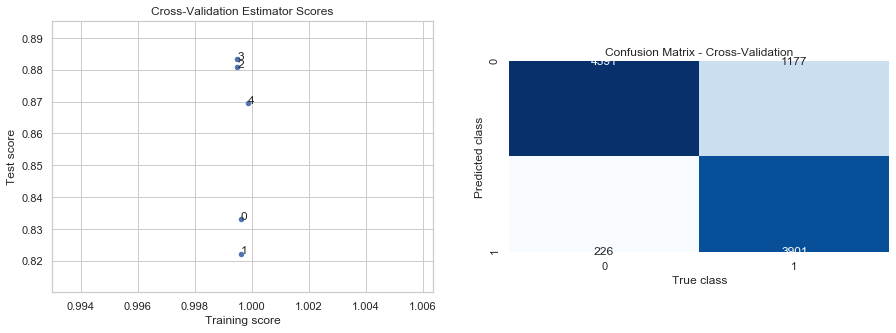

In [276]:
decision_tree(examples_b_cats,target_b_cats,True,False,fnames_b_cats)

The results were once again very similar to the type-non-specific analysis and the dogs-specific binary analysis, being all the conclusions taken from those results applicable here as well.

### Multiclass Classification

In [278]:
X_train_m_cats, X_test_m_cats, y_train_m_cats, y_test_m_cats = separate_split(df_processed2_m_balanced_cats_encoded,True)
examples_m_cats, target_m_cats, fnames_m_cats, tname_m_cats = separate_split(df_processed2_m_balanced_cats_encoded,False)

Number of examples and features for the training dataset:  (7663, 187)
Number of examples and features for the test dataset:  (2555, 187)


In [279]:
print("Number of Adoption=0 examples in the dataset: {}".format(np.count_nonzero(target_m_cats == 0)))
print("Number of Adoption=1 examples in the dataset: {}".format(np.count_nonzero(target_m_cats == 1)))
print("Number of Adoption=2 examples in the dataset: {}".format(np.count_nonzero(target_m_cats == 2)))
print("Number of Adoption=3 examples in the dataset: {}".format(np.count_nonzero(target_m_cats == 3)))
print("Number of Adoption=4 examples in the dataset: {}".format(np.count_nonzero(target_m_cats == 4)))

Number of Adoption=0 examples in the dataset: 2479
Number of Adoption=1 examples in the dataset: 2270
Number of Adoption=2 examples in the dataset: 1954
Number of Adoption=3 examples in the dataset: 1732
Number of Adoption=4 examples in the dataset: 1783


Best estimator:

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Test set results:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2479
         1.0       0.57      0.63      0.60      2270
         2.0       0.41      0.35      0.37      1954
         3.0       0.53      0.58      0.55      1732
         4.0       0.47      0.37      0.41      1783

    accuracy                           0.61     10218
   macro avg       0.58      0.59      0.58     10218
weighted avg       0.60      0.61      0.60     10218

Accuracy: 0.61 (+/- 0.16)


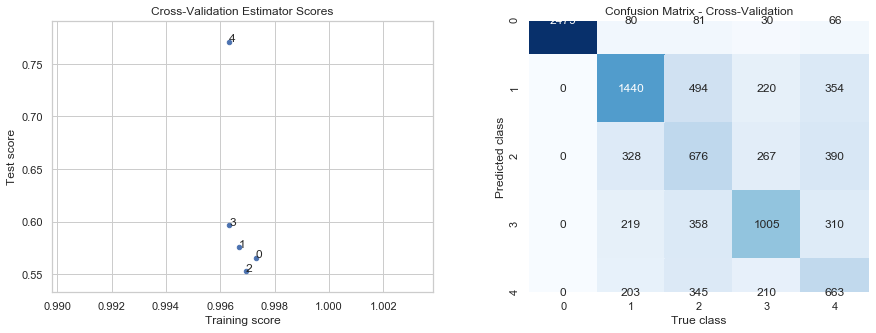

In [280]:
decision_tree(examples_m_cats, target_m_cats,False,False,fnames_m_cats)

The results were once again very similar to the type-non-specific analysis, being all the conclusions taken from the analysis of those results applicable here as well.

However, the scores for `AdoptionSpeed`=4 did not improve, as they did in the dogs multiclass analysis. In fact, the results were sligthly worse relatively to the type-non-specific analysis (*precision* 0.47 vs 0.51, *recall* 0.37 vs 0.43, *F1 score* 0.41 vs 0.46).

One hypothesis to explain this phenomena could be related to what we saw in EDA: the number of dogs with no adoption after 100 days (AdoptionSpeed = 4) is 37% higher than dogs being adopted on the same day (AdoptionSpeed = 0). On the other hand, we observe the opposite phenomena on cats. They tend to be adopted at ealier stages, being the number of cats with no adoption after 100 days (AdoptionSpeed = 4) 29% lower than cats being adopted on the same day (AdoptionSpeed = 0).

## 1.3. Classification - Results and Discussion 

The overall conclusion that we can take from these results, comparing to the benchmark, is that the data balancement was crucial to improve the models performance. The minority classes (mostly `Adoption`=0 and `AdoptionSpeed`=0) were probably being neglected in the learning proccess, since there weren't enough examples. On the other hand, majority class `AdoptionSpeed`=4 had great performance in the benchmark analysis

**** Resumir principais conclusões do binary ****

**** Resumir principais conclusões do multiclass ****

In a global analysis, the binary classification exhibited better performance than the multiclass task. That could be explained by the fact that each class had more examples to learn from, being the examples for each target class in the binary datasets almost the double of the examples from the 5 target classes of the multiclass dataset.

In respect to the type-specific analysis, comparing the cats and dogs classification tasks, their performances were very similar, but were also almost identical to the non-type-specific classification's performance.


## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

In order to perform Association Rule Mining, we need to transform our dataset in such a way that each line is a transaction, consisting of a list of features and their respective value.

E.g. transaction1 = [ `hasName` = 1, `type` = 2, `Age` = 35, (...) ]

We will use the balanced datasets for this task.

In [295]:
# This function encodes the previous dataset form into a Association Rule Mining friendly dataset
# which is a binary database
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def t_encoder(df):
    transactions=[] #list of transactions
    t=[] #list for each transaction
    s='' #string for building each item in the transaction

    rows = len(df.index) # nr of rows

    for i in range(rows):
        transactions.append(t)
        t=[]
        for c in list(df):
            s = c + "=" + str(df[c][i]) # build item strings
            t.append(s) # attach each item to the respective transaction

    transactions.pop(0) #eliminate first empty element

    #Compute binary database
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    binary_database = pd.DataFrame(te_ary, columns=te.columns_)
    
    return binary_database

In [296]:
t_binary = t_encoder(df_processed2_b_balanced)
t_multiclass = t_encoder(df_processed2_m_balanced)

## 2.2. Finding Associations

Since we are interested in exploring the associations between features and the target class, we will filter the dataset in order to obtain rules having `Adoption` or `AdoptionSpeed` as a consequent.

In [200]:
# This function returns the frequent itemsets and the rules obtained given a set of transactions
# It also filters those rules to show only the rules of interest in this analyisis,
# which are those having "Adoption" or "AdoptionSpeed" as a consequent.
# inputs:
# transactions - a binary database containing transactions
# min_support - the minimum support to use when defining frequent itemsets
# metric - the metric to use to filter rules
# min_threshold - the treshold of the specified metric
# binary - (boolean) whether the analysis is binary

def rules(transactions, min_support, metric, min_treshold, binary):
    #Compute itemsets with min_support indicated
    frequent_itemsets = apriori(transactions, min_support=min_support,use_colnames=True)
    
    # Generate association rules with confidence indicated
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_treshold)  
    
    # Transform consequents to string in order to filter
    rules["consequents"] = rules["consequents"].apply(lambda x: ' '.join(list(x))).astype("unicode")
    
    #Find consequents containing "Adoption" or "AdoptionSpeed"
    count=-1
    indexes=[]
    
    if binary:
        for i in rules["consequents"]:
            count+=1
            for j in i.split(' '):
                if j=="Adoption=1.0" or j=="Adoption=0.0":
                    indexes.append(count) # save indexes from rows containing Adoption as consequent
    else:
        for i in rules["consequents"]:
            count+=1
            for j in i.split(' '):
                if j=="AdoptionSpeed=0.0" or j=="AdoptionSpeed=1.0" or j=="AdoptionSpeed=2.0" or j=="AdoptionSpeed=3.0" or j=="AdoptionSpeed=4.0":
                    indexes.append(count) # save indexes from rows containing AdoptionSpeed as consequent

    new_rules = pd.DataFrame(columns=rules.columns)
    
    for i in indexes: # create new dataset containing the rules of interest only 
        new_rules = new_rules.append(rules.iloc[i])
    
    return frequent_itemsets, rules, new_rules

### Binary dataset

For this analysis, we will be using lift as a metric for building association rules, since it seems to be the most appropriate in this case. 

In this specific case, the Lift score can be interpreted as the *lift* that a given feature value would provide to our confidence in the rule for having the a value for the target class as a consequent. In this manner, rules having a value of Lift>1.0 show that having some feature values as antecedents increases the chances of occurence of some Adoption value, or in other words, there is a high association between that feature value and the target class, which is exactly the kind of casuality that is relevant to this problem. 

On the other hand, a minimum support of 0.45 means that for an itemset to be considered frequent it has to appear in at least 45% of transactions. This parameter was chosen in a compromise between finding rules of interest and assuring they are reliable.

In [ ]:
frequent_itemsets_b, rules_b, new_rules_b = rules(t_binary,0.45,"lift",1.0,True)

In [ ]:
print("In total we have ", frequent_itemsets_b.shape[0], " frequent itemsets.")
print("In total we have found ", rules_b.shape[0], " association rules.")

### Multiclass dataset

A minimum support of 0.19 was roughly the highest one we could find in order to have association rules of interest. 

In [290]:
frequent_itemsets_m, rules_m, new_rules_m = rules(t_multiclass,0.19,"lift",1.0,False)

In [291]:
print("In total we have found ", frequent_itemsets_m.shape[0], " frequent itemsets.")
print("In total we have found ", rules_m.shape[0], " association rules.")

In total we have found  6749  frequent itemsets.
In total we have found  161898  association rules.


## 2.3 Association Rules - Results and Discussion 

##### Binary dataset:

In [185]:
new_rules_b

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(hasVideo=0.0),Adoption=0.0,0.964661,0.499977,0.485619,0.503409,1.006864,0.003311,1.006911
3,(Health=1.0),Adoption=1.0,0.962345,0.500023,0.484739,0.503706,1.007365,0.003544,1.007420
79,(hasVideo=0.0),Health=1.0 Adoption=0.0,0.964661,0.477606,0.463943,0.480939,1.006978,0.003215,1.006421
81,"(Health=1.0, hasVideo=0.0)",Adoption=1.0,0.928257,0.500023,0.464314,0.500200,1.000353,0.000164,1.000353
83,(Health=1.0),Adoption=1.0 hasVideo=0.0,0.962345,0.479042,0.464314,0.482481,1.007179,0.003310,1.006646


Looking at the table, we are not surprised to see a consequent support of ~50%, since the dataset has an equal number of `Adoption`=0 and `Adoption`=1 examples. This is also why the rule support is low, as it cannot be higher than the consequent support.

The antecedent support shows that not having a video (`hasVideo`=0.0) and being healthy (`Health`=1.0) are very common traits in the dataset, which is concordant to what we saw in the EDA.

Some rules are not very informative: `hasVideo`=0.0 appears related to both `Adoption`=0 and `Adoption`=1. However, `Health`=1.0 is associated with `Adoption`=1 only, which is what we could expect intuitively.

The lift scores do not show a very high association between the items, considering that a lift of 1.0 does not express meaningful interaction between antecedents and consequents. The fact that the antecedents' support is so high makes us consider the hypothesis of these associations being a sole result of chance, since the antecedents appear in almost every example in the dataset.

##### Multiclass dataset

In [294]:
new_rules_m

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Health=1.0),AdoptionSpeed=1.0,0.964211,0.200010,0.194148,0.201354,1.006723,0.001297,1.001684
2,(hasVideo=0.0),AdoptionSpeed=1.0,0.959064,0.200010,0.193242,0.201491,1.007405,0.001421,1.001855
5,(Health=1.0),AdoptionSpeed=2.0,0.964211,0.200010,0.194339,0.201552,1.007712,0.001487,1.001932
7,(Health=1.0),AdoptionSpeed=3.0,0.964211,0.199962,0.193290,0.200465,1.002514,0.000485,1.000629
9,(hasVideo=0.0),AdoptionSpeed=4.0,0.959064,0.200010,0.194243,0.202534,1.012623,0.002421,1.003166


As explained earlier, we are not surprised to see a consequent support of ~20%, since the dataset has an approximately equal number of examples for each target. This is also why the rule support is low, as it cannot be higher than the consequent support.

Once again, the antecedent support is very high, reflecting the intrinsically biased distribution of `hasVideo` and `Health` values in the dataset.

These rules are concordant to what we saw in the binary analysis, in terms of healthy pets being prone to get adopted. However, they are not very informative, as `Health`=1.0 is associated to `AdoptionSpeed`=1.0, `AdoptionSpeed`=2.0 and `AdoptionSpeed`=3.0. We conclude that being healthy is not a discriminatory enough trait to predict the adoption speed with such a fine grain level of detail.

The lift scores are very similar to those of the binary analysis, not showing a high association between the items. Once again we propose that these associations may be a sole result of chance, since the antecedents appear in almost every example in the dataset.

## 2.4. Preprocessing Data for Clustering

For this task we will use the same processed dataset as we used for the Binary and Multiclass Classification tasks, df_processed2_b_balanced_encoded and df_processed2_m_balanced_encoded. k-Means uses distance computation as a metric in its algorithm, and hence cannot handle categorical variable directly. That is the reason why we use the encoded datasets.

In [300]:
# SPLIT THE DATASET
nc_b = df_processed2_b_balanced_encoded.shape[1] # number of columns
table_X_b = df_processed2_b_balanced_encoded.iloc[:, 0:nc_b-1] # get features ignoring AdoptionSpeed
table_y_b = df_processed2_b_balanced_encoded.iloc[:, nc_b-1] # get class (last columns) 

nc_m = df_processed2_m_balanced_encoded.shape[1] # number of columns
table_X_m = df_processed2_m_balanced_encoded.iloc[:, 0:nc_m-1] # get features ignoring AdoptionSpeed
table_y_m = df_processed2_m_balanced_encoded.iloc[:, nc_m-1] # get class (last columns) 

Each dimension has the same weight in the k-means algorithm, but since our data has dimensions in different scales (some are binary, ranging from 1 to 0 while others are continuous, ranging from 0 to 250 - `Age`) we will proceed to standardize the data, in order to avoid distortion on the relative near-ness of observations.

In [301]:
# STANDARDIZING THE DATA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled_b = scaler.fit_transform(table_X_b)
data_scaled_m = scaler.fit_transform(table_X_m)

## 2.5. Finding Groups

In order to find out if it's possible to find groups of pets with the same/similar adoption speed, we will look at the k=2 and k=5 clusters obtained from k-Means and determine whether they coincide with the AdoptionSpeed groups.

In [302]:
from sklearn.cluster import KMeans
kmeans_b = KMeans(n_clusters=2, random_state=0)
kmeans_m = KMeans(n_clusters=5, random_state=0)

In [303]:
# Train K-means
kmeans_b = kmeans_b.fit(data_scaled_b)
kmeans_m = kmeans_m.fit(data_scaled_m)

In [304]:
# This function produces a confusion matrix with the percentual membership
# (of the points in each cluster) to a given feature

def df_confusion(cluster, table_a):
    df = pd.DataFrame(set(table_a))
    df = df.set_index(0)

    for i in set(cluster): df[i] = 0 
    i=0
    while i < len(cluster):
        df.loc[table_a[i], cluster[i]]+=1
        i += 1
    for i in set(df.columns): 
        Total = df[i].sum()
        for j in set(df.index):
            df.loc[j, i] = (df.loc[j, i] / Total)
    return df

### 2.5.1 Binary analysis

Text(111.5, 0.5, 'true label')

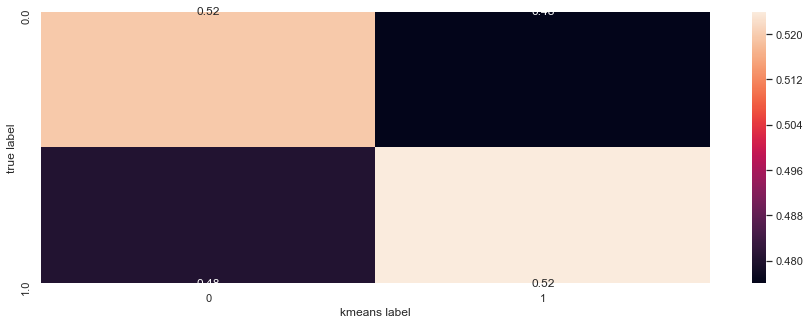

In [305]:
# Compare membership for binary dataset
df1 = df_confusion(kmeans_b.labels_, table_y_b)
ax = sns.heatmap(df1, annot=True)
ax.set_xlabel('kmeans label')
ax.set_ylabel('true label')

### 2.5.1 Multiclass analysis

Text(111.5, 0.5, 'true label')

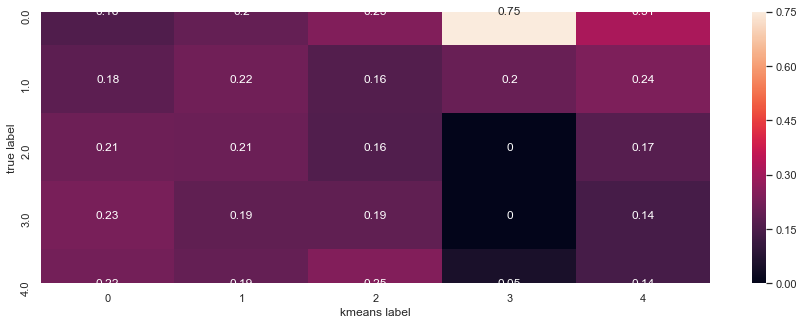

In [306]:
# Compare membership for multiclass dataset
df2 = df_confusion(kmeans_m.labels_, table_y_m)
ax = sns.heatmap(df2, annot=True)
ax.set_xlabel('kmeans label')
ax.set_ylabel('true label')

## 2.6. Clustering - Results and Discussion 

In respect to the Binary analysis, we can see in the confusion matrix that the negative examples are evenly distributed through both clusters obtained from k-means, and the same happens for the positive examples. Thus, we conclude that the groups obtained from k-means do not coincide with the groups from the target class. 

In the Multiclass analysis, the confusion matrix indicates that none of the clusters hold more than 30% of examples from any AdoptionSpeed class, thus we conclude that there is no evident agreement between the predicted clusters and the real target groups.

These poor results can be explained due to the complexity and high dimensionality of the dataset, because when we have so many features (378) distance interpretation isn’t so obvious. An additional step employing Principal Component Analysis to reduce dimensionality might've helped to get more productive results. 

## 3. Final Comments and Conclusions